## Sobre o estudo

Nosso estudo tem como objetivo avaliar a performance de redes convolucionais para classificação de áudio. Para isso, utilizamos o Free Spoken Digit Dataset, popularmente referenciado como audioMNIST, dataset que contém 3000 áudios de aproximadamente 1 segundo (Há audios com 2 segundos, por exemplo) pertencendo as classes de 0 a 9 em que seus locutores pronunciam o número correspondente a classe(em inglês).

Nós mostraremos as técnicas de pré-processamento avaliadas durante os cinco meses que trabalhamos com esses dados, a redes que elaboramos para lidar com o problema para enfim apresentarmos nossa proposta de fluxo de pré-processamento e rede neural para a resolução do problema de classificação dos áudios do FSDD, se tivemos um bom resultado ou não e o porquê.

-----

## About the study

Our study has as primary objective to evaluate the performance of convolutional neural network to the audio classification problem. We will use the Free Spoken Digit Dataset, also known as "audio MNIST", dataset with 3000 audios of mostly about 1 second duration (there are, however, 2 seconds audios for example) that belongs to classes between 0 and 9 wich the speakers pronounce the correspondent number (in english)

We will show the pre-process techniques evaluated during the five months we worked with this data, the network we elaborated to deal with the problem to finally present our pre-processing and model workflow to solve the FSDD audio classification problem, show if we had a good result or not and why.


## Bibliotecas/Libraries

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, metrics, optimizers
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from pathlib import Path
import IPython.display as ipd
import librosa
import librosa.display
from keras.preprocessing import image

## Se Estiver no Google Colab, rode

-----
## If You're in Google Colab, run

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Audio MNIST'
os.chdir(path)
os.listdir()

['free-spoken-digit-dataset',
 'mfcc',
 'audioMNIST.csv',
 'AudioMNIST.ipynb',
 'CroppedResNET.h5',
 'Github.ipynb']

## Baixando o Dataset
## Downloading the Data


Já que não possuímos os direitos do dataset FSDD, embora ele seja público, nós optamos por deixar o comando para que ele seja baixado. Para que possa ver tudo o que foi feito até o momento, é **necessário que se rode essa célula, se não, não haverá dataset**. Créditos a [Zohar Jackson](https://github.com/Jakobovski/) por disponibilizar os dados.

-----

Since we do not own any rights of the FSDD dataset, even if it is public, we choose to let the command for him to be downloaded. To see everything that has been done so far in this work, its **necessary to run this cell, cause if you don't, there will be no audio data**. All credits to [Zohar Jackson](https://github.com/Jakobovski/) for the data.

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

## Conhecendo o dataset
## Knowing the data

Nesse notebook, para descomplicação, nós lidaremos com um arquivo já processado: o audioMNIST.csv. Nele estarão todas as informações relevantes do Free Spoken Digit Dataset, como digito correspondente, caminho até o áudio, etc.

-----

In this notebook, for synthesis and easy understanding, we will handle with the audioMNIST.csv file. In this file will be all relevant info about the Free Spoken Digit Dataset, like correspondent digit, path to the audio file, etc.

In [ ]:
df = pd.read_csv('audioMNIST.csv')
df.head()

,File,digit,Speaker,Index,Pathing,mfcc,mfcc path
0,0_george_0.wav,0,george,0,free-spoken-digit-dataset/recordings/0_george_...,0_george_0.wav.png,mfcc/0_george_0.wav.png
1,0_george_1.wav,0,george,1,free-spoken-digit-dataset/recordings/0_george_...,0_george_1.wav.png,mfcc/0_george_1.wav.png
2,0_george_10.wav,0,george,10,free-spoken-digit-dataset/recordings/0_george_...,0_george_10.wav.png,mfcc/0_george_10.wav.png
3,0_george_11.wav,0,george,11,free-spoken-digit-dataset/recordings/0_george_...,0_george_11.wav.png,mfcc/0_george_11.wav.png
4,0_george_12.wav,0,george,12,free-spoken-digit-dataset/recordings/0_george_...,0_george_12.wav.png,mfcc/0_george_12.wav.png


Agora que já temos nossa tabela, podemos começar a conhecer melhor os nossos dados e o problema. Antes de manipular nosso dados, vamos aprender um pouco mais sobre eles.

-----

Now that we have our table, we can start to known better our data and the problem. Before manipulating our data, lets learn a little more about it. 



In [ ]:
df['digit'].value_counts()

9    300
7    300
5    300
3    300
1    300
8    300
6    300
4    300
2    300
0    300
Name: digit, dtype: int64

In [ ]:
df['digit'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Sabemos, então, que há 10 classes: os dígitos de 0 a 9. Mas quantas pessoas estão falando esses dígitos? Para saber disso, analisaremos a coluna "Speaker", os nossos locutores.

-----

We know, them, that there are 10 classes: the digits between 0 and 9. But how many speakers we have? To find out, lets analise the "Speaker" column.

In [ ]:
df['Speaker'].value_counts()

lucas       500
nicolas     500
yweweler    500
jackson     500
theo        500
george      500
Name: Speaker, dtype: int64

In [ ]:
df['Speaker'].unique()

array(['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'],
      dtype=object)

Podemos também estabelecer uma relação entre as classes e os locutores utilizando a função pd.crosstab().

-----

We can also stablish a relation between classes and speaker using the pd.crosstab() function.

In [ ]:
pd.crosstab(df['Speaker'],df['digit'])

digit,0,1,2,3,4,5,6,7,8,9
Speaker,,,,,,,,,,
george,50,50,50,50,50,50,50,50,50,50
jackson,50,50,50,50,50,50,50,50,50,50
lucas,50,50,50,50,50,50,50,50,50,50
nicolas,50,50,50,50,50,50,50,50,50,50
theo,50,50,50,50,50,50,50,50,50,50
yweweler,50,50,50,50,50,50,50,50,50,50


Sabemos então que o Dataset está balanceado tanto em classes quanto em locutores. Nossa compreensão sobre o Dataset está quase completa, só falta ouvir os áudios para saber exatamente com o que estamos lidando!

-----

We know, them, that our data is balanced in classes and speakers. Our understanding about the dataset is almost complete, the only thing that's left is listen to the audios to know exactly what are we dealing with!

In [ ]:
audio_list = []
for item in df['digit'].unique():
  df_st = df.query('digit == {}'.format(item)).copy(deep=True).sample(frac=1).reset_index(drop=True)
  audio_list.append(df_st['Pathing'][0])
for wav in audio_list:
  display(ipd.Audio(wav))

Agora que já conhecemos nosso dataset, podemos começar a manipulá-lo.

-----

We know more than enough about our data. Now we can finally start.

## Espectrogramas

-----

## Spectrograms

Espectrogramas são gráficos de densidade de energia gerados a partir de alguma transformação, a mais popular sendo ela a Transformada de Fourier. No eixo X temos o tempo do áudio e a frequência no eixo y, enquanto as cores indicam a presença do áudio naquela frequência. Essencialmente, o espectrograma é um gráfico de superfície, porém é comum utilizar cores para representar a 3a dimensão ao invés de gerar um gráfico planar.

Os espectrogramas são representações visuais de áudio de comum uso para análises e também podem ser utilizados como dados de entrada em redes neurais convolucionais. Vamos ver os espectrogramas dos áudios que acabamos de escutar.

-----

Spectograms are energy density graphs generated from some mathematic transformation, the most used being the Fourier Transformation In the x axle, we have the time of the audio and in the y axle the audio frequency, while the collors indicate the audio energy in that frequency. Essentialy, a spectrogram is a surface chart, therefore, is commom to use collors to represent the third dimmension instead of plane graphs.

Spectrograms are visual representations of audio data mostly used to analysis and also as input for CNNs. Lets see the spectograms of the audio data we just listened to.

free-spoken-digit-dataset/recordings/0_jackson_30.wav


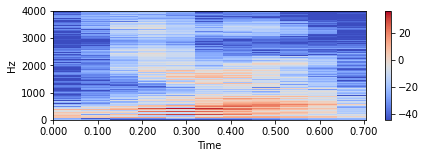

free-spoken-digit-dataset/recordings/1_theo_33.wav


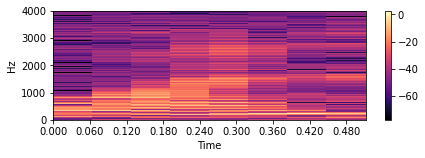

free-spoken-digit-dataset/recordings/2_jackson_20.wav


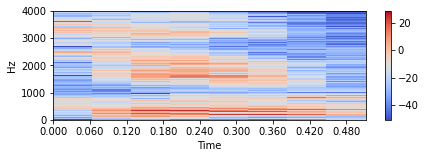

free-spoken-digit-dataset/recordings/3_nicolas_49.wav


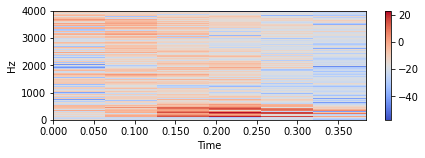

free-spoken-digit-dataset/recordings/4_nicolas_47.wav


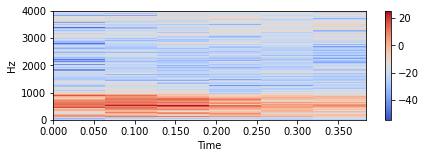

free-spoken-digit-dataset/recordings/5_theo_19.wav


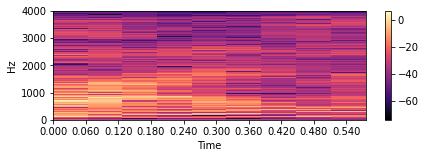

free-spoken-digit-dataset/recordings/6_lucas_44.wav


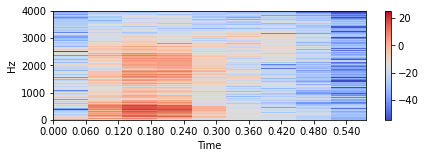

free-spoken-digit-dataset/recordings/7_theo_6.wav


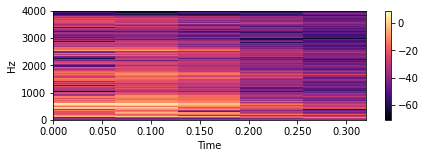

free-spoken-digit-dataset/recordings/8_theo_34.wav


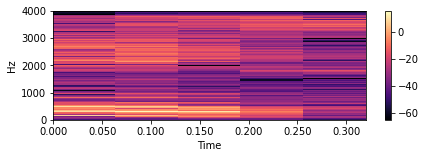

free-spoken-digit-dataset/recordings/9_theo_0.wav


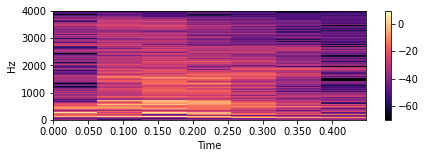

In [ ]:
for item in audio_list:
  print(item)
  x , sr = librosa.load(item, sr=None)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(7, 2))
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()
  plt.show() 

Embora seja possível chegar aos 70% de acurácia utilizando apenas espectrogramas, eles não são a melhor opção e sim o precursor do que se tornará nossa abordagem final: o MFCC. 

Entre os motivos os quais os espectrogramas não são os mais indicados para nosso problema estão a diferença tanto de duração quanto de frequência entre os áudios. Seria errado encarar esses gráficos como iguais se expressam dados em escalas diferentes e, nos nossos espectrogramas, a intensidade dos valores se dispersa tanto em tempo quanto em frequência. Como veremos adiante, o MFCC diminui a gravidade desses problemas.

-----


Although it's possible to reach nearly 70% accuracy using only spectrograms, they aren't the best option: they are the precursor of what will became our final input: the MFCC.

Between the reasons that spectrograms aren't the best candidates to our problem are the difference of duration and frequency of the audios. It would be wrong face this charts as equals if they express different data in different scales and, in our spectrograms, the intensity of the values disperses too much in time and frequency. As we will see ahead, the MFCC shrinks the severity of these problems.

## MFCCs

O MFCC (Mel-Frequency Cepstral Coefficients) é uma técnica muito popular e efetiva na tarefa de classificação de áudio. MFCCs podem ser encarados como "espectrogramas logarítmos de espectrogramas". Na prática, o MFCC centraliza pedaços de um áudio e aplica transformações cossenóides lineares a um espectrograma em escala logarítmica.

A biblioteca librosa nos permite gerar um MFCC de forma fácil e rapida como veremos a seguir.

-----

The MFCC (Mel-Frequency Cepstral Coefficients) is a very popular and efective technique in the audio classification task. MFCCs can be faced as "log-scale spectrograms of a spectrograms". In practice, a MFCC centralize pieces of an audio and apply linear cosinenoids transformations to a log-scale spectrogram.

As we will see ahead, the librosa library allows us to generate a MFCC in a fast and easy way.

free-spoken-digit-dataset/recordings/0_jackson_30.wav


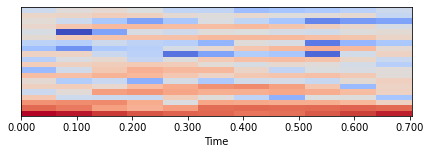

free-spoken-digit-dataset/recordings/1_theo_33.wav


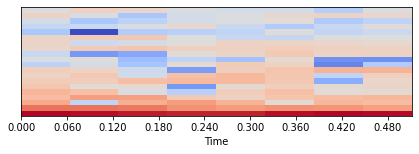

free-spoken-digit-dataset/recordings/2_jackson_20.wav


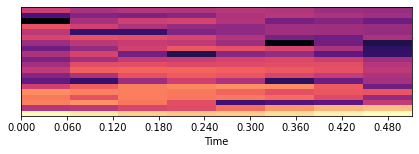

free-spoken-digit-dataset/recordings/3_nicolas_49.wav


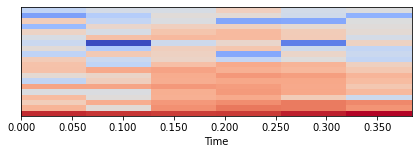

free-spoken-digit-dataset/recordings/4_nicolas_47.wav


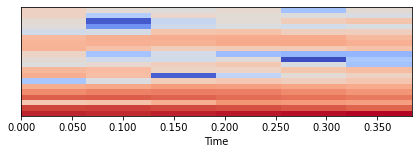

free-spoken-digit-dataset/recordings/5_theo_19.wav


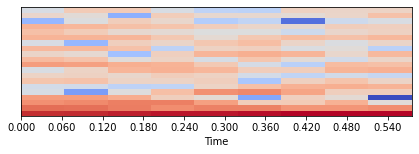

free-spoken-digit-dataset/recordings/6_lucas_44.wav


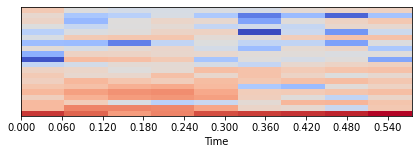

free-spoken-digit-dataset/recordings/7_theo_6.wav


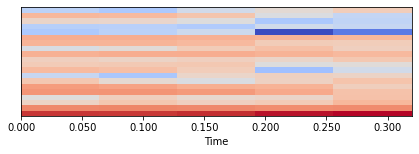

free-spoken-digit-dataset/recordings/8_theo_34.wav


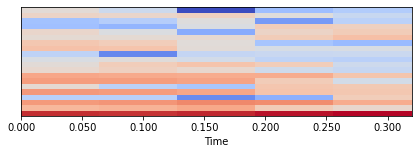

free-spoken-digit-dataset/recordings/9_theo_0.wav


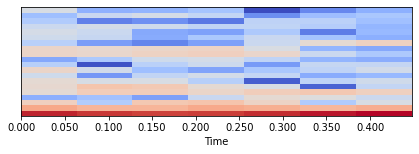

In [ ]:
for item in audio_list:
  print(item)
  x , sr = librosa.load(item, sr=None)
  X = librosa.feature.mfcc(x, sr=sr) #Gera o MFCC//Generate the MFCC
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(7, 2))
  librosa.display.specshow(Xdb, sr=sr, x_axis='time') #Mostra o gráfico do MFCC/Show the MFCC graph
  plt.show() 

Algumas diferenças aqui já são visivelmente notáveis. Isso se dá pelo fato do MFCC centralizar partes do áudio e também porque o eixo y do gráfico do MFCC tem significado diferente: ele é dividido em n_mfcc (um parâmetro da funçao librosa.feature.mfcc, default 20) partes na janela de tempo analisada/centralizada, cada um dessas partes sendo um coeficiente cepstral(não há tradução) e tendo a intensidade da sua presença demonstrada em cores. 

É facil ver as janelas de tempo centralizadas no gráfico, quase como que se tivesse uma linha dividindo elas na imagem: o problema é que ainda não temos controle nenhum sobre essas janelas e os problemas de escala em duração persistem pois, embora a dispersão de frequências já tenha sido cuidada nessa abordagem, o número de janelas analisadas ainda é diferente entre os áudios devido as suas durações. 

Ainda há outras preocupações: não é recomendado utilizar o áudio cru, pois, mesmo que a função aplique já as transformadas de Fourier, existem outros pré-processamentos necessários: a pré-enfase, o janelamento e a segmentação, como discutiremos a seguir. 

----

Some differences are already visible notables. The why is because the MFCC centralizes pieces of the audio and also cause the y axle of the MFCC graph has a different meaning than before: he is divided by the n_mfcc param (a param of the librosa.feature.mfcc function, default 20) in the time frame analised, every one of this pieces being a cepstral coefficient and having the intensity of your presence shown as collors.

Its easy to see the time windows centralized in the graph, almost as if there was a line dividing them in the immage: the problem is that we still have no control about the size of this windows and the scale problems of durantions persist cause, even the frequency discrepancy has already been dealed with in this technique, the number of windows analised is still different between the audio data.

There are also others worries: it's not recommandable using the raw audio, cause, even if the function apply the Fourier transformation, there are the necessity of others pre-processing: the pre-emphasis, the windowing and the segmentation, as we will discuss next.

## Pré-Processamento de MFCCs

----

## MFCCs pre-processing

### Pré-Enfase

-----

### Pre-Emphasis


Como já dito anteriormente, espectrogramas são gráficos que expressam energia da fonte e, na maioria dos casos, a energia de um áudio está concentrada nas frequências menores. A idéia da pré-ênfase é enfatizar as frequências maiores. Essa ênfase em frequências inferiores acontece por coisas como distância entre a fonte emissora e o aparelho captador do áudio, acústica, erros de captação, entre outros motivos.

No fundo, a pré-enfase filtra o espectro para se assimilar ao máximo a captação limpa do som real.

A biblioteca librosa conta com a pré-enfase já implementada, como veremos a seguir.

----

As we already told, spectrograms are graphs that express the energy of the font of the audio and, in mostly cases, the energy of an audio is concentraded on lower frequencys. The idea of pre-emphasis is to emphasize the bigger frequencies. This emphasis in lower frequencies happens because of things like distancy between the font and the microphone, acoustics, captarion erros, et cetera.

In practice, the pre-emphasis process filter the spectrum to aproximate the most of a clean captation of the real sound.

The librosa library has the pre-emphasis alreay implemented.

free-spoken-digit-dataset/recordings/0_jackson_30.wav


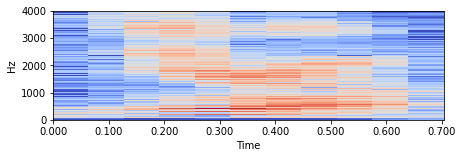

free-spoken-digit-dataset/recordings/1_theo_33.wav


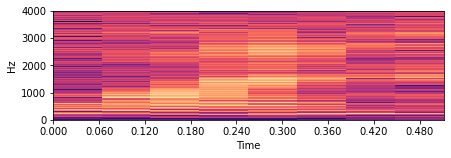

free-spoken-digit-dataset/recordings/2_jackson_20.wav


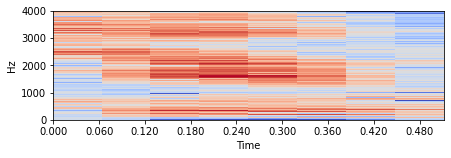

free-spoken-digit-dataset/recordings/3_nicolas_49.wav


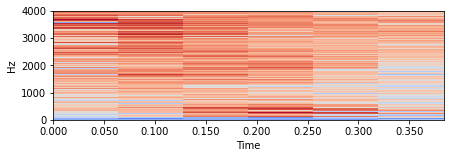

free-spoken-digit-dataset/recordings/4_nicolas_47.wav


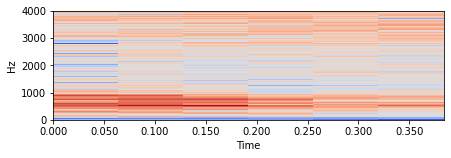

free-spoken-digit-dataset/recordings/5_theo_19.wav


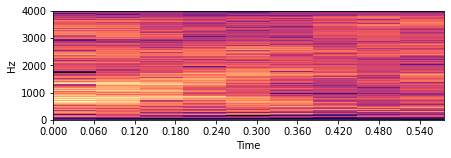

free-spoken-digit-dataset/recordings/6_lucas_44.wav


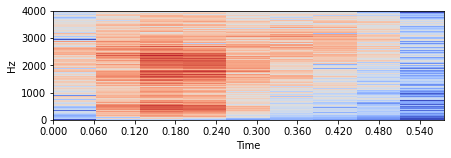

free-spoken-digit-dataset/recordings/7_theo_6.wav


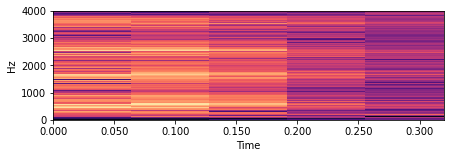

free-spoken-digit-dataset/recordings/8_theo_34.wav


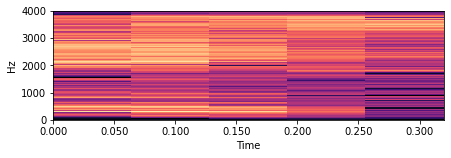

free-spoken-digit-dataset/recordings/9_theo_0.wav


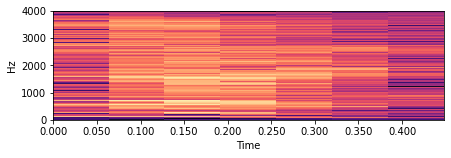

In [ ]:
for item in audio_list:
  print(item)
  x , sr = librosa.load(item, sr=None)
  x = librosa.effects.preemphasis(x, coef=0.97, zi=None, return_zf=False)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(7, 2))
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') #Mostra o gráfico do MFCC
  plt.show() 

### Janelamento e Segmentação

------

### Windowing and Segmentation

Como é possível visualizar nos gráficos do MFCC, ele centraliza pontos específicos do áudio (expresso na divisão do eixo x dos gráficos do MFCC). Justamente por essa centralização de algumas partes do áudio que existe o processo de janelamento e segmentação: nós dividimos o áudio a partir de uma janela (em milissegundos) e deslocamos essa janela em um passo menor do que seu tamanho. Dessa forma, há alguma repetição, mas mais partes do áudio são centralizadas para análise dos coeficientes cepstrais.

A funçao MFCC pode fazer o processo de janelamento e segmentação, sendo o parâmetro __window_lenght__ o tamanho da janela e o parâmetro __hop_size__ o tamanho do salto. Vamos visualizar o MFCC após esse processo.

------

As its possible to see in the MFCC graphs, it centralize pieces of the audio (this division is expressed in the x axle of the MFCC). Precisely because of this centralization in some parts that exist the windowing and segmentation process: we divide the audio from a window (in milliseconds) and we deslocate this window in a step lower than the size of the window. That way, some parts of the audio repeats, but more parts of the sound are centralized in the cepstral coefficients analysis process.

The MFCC function can make this process, being the __window_lenght__ the size of the window and the __hop_size__ the size of the step. Lets look at the MFCC after this process.

free-spoken-digit-dataset/recordings/0_jackson_30.wav


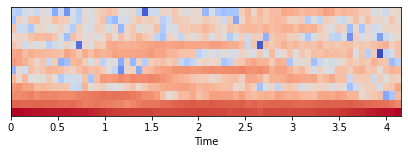

free-spoken-digit-dataset/recordings/1_theo_33.wav


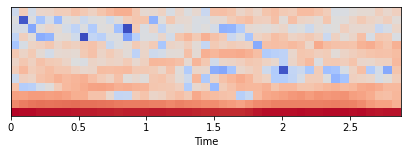

free-spoken-digit-dataset/recordings/2_jackson_20.wav


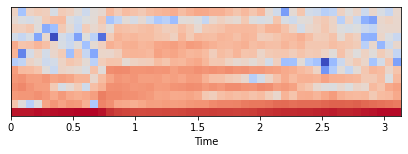

free-spoken-digit-dataset/recordings/3_nicolas_49.wav


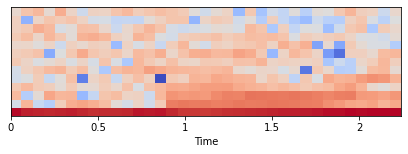

free-spoken-digit-dataset/recordings/4_nicolas_47.wav


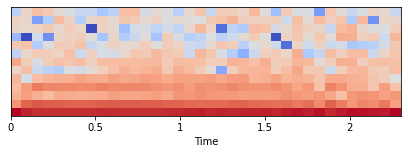

free-spoken-digit-dataset/recordings/5_theo_19.wav


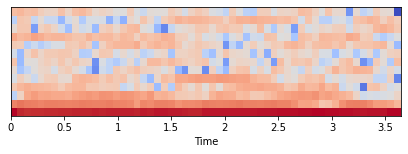

free-spoken-digit-dataset/recordings/6_lucas_44.wav


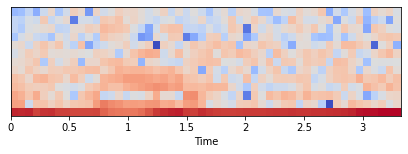

free-spoken-digit-dataset/recordings/7_theo_6.wav


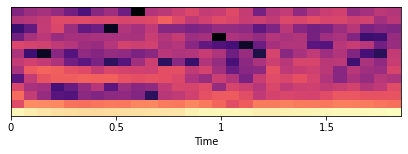

free-spoken-digit-dataset/recordings/8_theo_34.wav


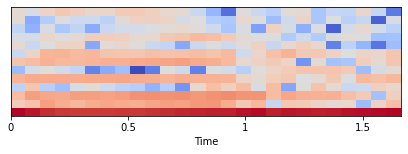

free-spoken-digit-dataset/recordings/9_theo_0.wav


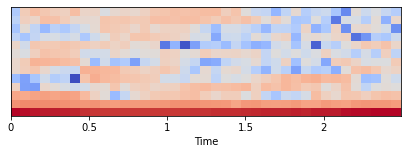

In [ ]:
#0.01*frequência significa que nosso salto será de 10 milissegundos
#Enquanto 0.025*frequência indica que serão analisadas janelas de 25 ms
########################
#0.01*frequency indicates that our step will be of 10 milliseconds
#And 0.025*frequency shows that it will be analized windows of 25 ms size.


for item in audio_list:
  print(item)
  x , sr = librosa.load(item, sr=None)
  X = librosa.feature.mfcc(y=x, sr=sr , n_mfcc=13, dct_type=2, hop_length=(int)(0.01*sr), win_length=(int)(0.025*sr), window='hann', center=True)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(7, 2))
  librosa.display.specshow(Xdb, sr=sr, x_axis='time') #Mostra o gráfico do MFCC
  plt.show() 

Note que a duração dos áudios nesses novos gráficos, em relação aos primeiros, tem uma duração maior. Isso se dá ao fato do deslocamento da janela ser menor do que seu tamanho, evidenciando a sobreposição do áudio e a centralização de mais partes do arquivo nessa representação, diminuindo o número de fragmentos não-centralizados do áudio.

Notes that the durations of the audio in this new graphs, in relation of the first ones, are bigger. That's because cause the size of the hop is lower than the size of the window: it will generate some overlapping in the data and also lower the non-centralized parts of the data.

## Validando nossa abordagem

---

## Validating our approach

Agora já escolhemos nossa técnica e temos motivos suficientes para acreditar que ela é adequada. Dito isso, chegou a hora de validar a nossa abordagem e, como um dos nossos objetivos é justamente avaliar o desempenho de redes convolucionais para a tarefa de classificação de áudio, utilizaremos uma adaptação quase fiel de uma CNN muito famosa e empiricamente eficaz a muitos problemas: a ResNet.

Como as CNN são recorrentes em classificação de imagens, daremos para ela o gráfico dos MFCCs gerados. Estes estão disponíveis na pasta "MFCC".

-----

Now we already choose our approach and have enough reasons to believe that it is accurate. With hat said, it's time to validade our approach and, as one of our goals is precisely evaluate the perforamnce of convolutional neural networks to the audio classification task, we will utilize a almost-equal adaptation of a very famous and empirically useful CNN to many problems: the ResNet.

As CNNs are recurrent used in image classification, we will feed to it the MFCC graphs. They are available in the "MFCC" directory.

### Construindo a ResNet

------

### Building the ResNet

In [ ]:
def addResidualUnit(hu, activation, previous_layers):
  x = layers.Conv2D(hu, 3, strides=1, padding="same", )(previous_layers)
  x = layers.BatchNormalization()(x)
  x = layers.Activation(activation)(x)
  x = layers.Conv2D(hu, 3, strides=1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  ru = layers.concatenate([x, previous_layers])
  ru = layers.Activation(activation)(ru)
  return ru

In [ ]:
def addSkipConection(hu, activation, previous_layers):
  x = layers.Conv2D(hu, 3, strides=2, padding="same")(previous_layers)
  x = layers.BatchNormalization()(x)
  x = layers.Activation(activation)(x)
  x = layers.Conv2D(hu, 3, strides=1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  y = layers.Conv2D(hu, 1, strides=2, padding="same")(previous_layers)
  y = layers.BatchNormalization()(y)
  ru = layers.concatenate([x, y])
  ru = layers.Activation(activation)(ru)
  return ru

In [ ]:
def build_resnet(inputSize, activation='relu', dropout=True):
  image_input = layers.Input(shape=inputSize, dtype='float32',name='image')
  x = layers.Conv2D(64, 7, strides=2, padding="same")(image_input)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(64, 7, strides=2, padding="same")(x)
  x = layers.MaxPooling2D()(x)
  x = addResidualUnit(64, activation, x)
  x = addResidualUnit(64, activation, x)
  x = addSkipConection(128, activation, x)
  x = addResidualUnit(128,activation, x)
  x = addResidualUnit(128,activation, x)
  if dropout:
    x = layers.Dropout(0.5)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(512)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation(activation)(x)
  clf = layers.Dense(10, activation='softmax')(x)
  model = models.Model(image_input, clf)
  model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc'])
  return model

Vamos ver como ficou nossa ResNet.

------

Let's look at our CNN architecture.

In [ ]:
model = build_resnet((148, 48, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 148, 48, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 74, 24, 64)   9472        ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 37, 12, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 19, 6, 64)    200768      ['max_pooling2d[0][0]']      

Há um porém: esse modelo não é adequado. Por nos afeiçoarmos muito a essa adaptação da ResNet - afinal ela chegou perto dos 70% de acurácia nesse problema utilizando espectrogramas e já havia tido uma boa performance em um estudo anterior a esse - nós, inconscientemente, ignoramos um fato: dessa vez estamos manipulando gráficos de coisas pequenas, traduzido este em uma imagem 148x48 pixels, um tamanho muito pequeno para uma rede tão densa quanto a que propusemos. 

Como é possível enxergar no sumário do modelo, nossa rede trabalharia por diversas camadas com um material 9x3 e, depois, mais algumas camadas com representações 5x2, amostras muito pequenas para se trabalhar por tantas etapas. Nós demoramos para perceber isso e por algum tempo esse problema, que parece pequeno, foi o que segurou nosso progresso no estudo. Com a lição aprendida e partindo que, para os curiosos, não é difícil reproduzir nossa falha com o material que disponibilizamos, vamos a próxima discussão do trabalho: aumentar as amostras ou diminuir a rede?

Nós escolhemos diminuir a rede, não só pelo ganho de tempo e menores chances de overfitting com uma CNN menos densa, mas também porque nesse caso faz pouco sentido aumentar a dimensão da imagens: ao contrário de, por exemplo, imagens médicas, em que quanto maior a imagem capturada mais detalhes ela terá e, portanto, diminuí-la prejudica a representação, no caso de um gráfico pequeno e já bem dividido em coeficientes e janelas de tempo, o supersampling desses MFCCs apenas iria adicionar pixeis numa representação já ideal: se o gráfico já é bem representado de forma pequena, para quê aumentar?

-------

There is a issue: our model is not adequate. Since we already used this ResNet adaptation on other problem, we getted too much attached to this model and ignored a fact: in this problem we are manipuled small images, with just 148x48 pixels, a small size to a too dense network like this one.

Its possible to see in this model summary that our network would work too much layers with a 9x3 material and, after that, more layers with 5x2 samples, sizes too small to work for so many layers. We taked a long time to realize that and for this reason this issue, who look small in first sight, hold us from progressing the study. With the lesson learned and know that, for the curious one, is not hard to reproduct our error with the available material, let's move forward to the next discussion: increase the size of the images or decrease the depth of the network?

We choose to decrease the network, not just for the time we would spare with a smaller model, but also because in this cause there is no big advantage in increasing the size of the images: instead of, for example, the case of medical images, where the bigger the image the bigger the details and, therefore, decrease the size of them would harm the representation, in the case of a small graph and already well divided in coefficients and time windows, the supersampling of this MFFCs would only add pixels in a already ideal represenation: if the graph are already well representaded in a small image, why would you increase it?

## A Nova Rede

-------

## The New Network

In [ ]:
def build_CroppedResNET(inputSize, activation='relu', dropout=True):
  image_input = layers.Input(shape=inputSize, dtype='float32',name='image')
  x = layers.Conv2D(64, 7, strides=2, padding="same")(image_input)
  x = addResidualUnit(64, activation, x)
  x = addSkipConection(128, activation, x)
  x = addResidualUnit(128,activation, x)
  x = addResidualUnit(128,activation, x)
  if dropout:
    x = layers.Dropout(0.5)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(512)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  clf = layers.Dense(10, activation='softmax')(x)
  model = models.Model(image_input, clf)
  model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc'])
  return model

In [ ]:
new_model = build_CroppedResNET((148, 48, 3))
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 148, 48, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 74, 24, 64)   9472        ['image[0][0]']                  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 74, 24, 64)   36928       ['conv2d_13[0][0]']              
                                                                                                  
 batch_normalization_12 (BatchN  (None, 74, 24, 64)  256         ['conv2d_14[0][0]']        

Agora que já temos nossa rede chegou a hora de carregar as imagens, anteriormente salvas, e descobrir a eficácia do modelo.

---

Now that we have our model, let's load the images, saved on the "MFCC" directory, and find out the model efficiency.

## Testando o Modelo

-----

## Testing the Model

### Carregando os dados

------

### Loading the data

In [ ]:
def loadMFCCs(df):
  img = image.load_img( df['mfcc path'][0],target_size=(148,48, 3))
  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  for i in range(1, df.shape[0]):
    #print('Loading Image #', df.index[i])
    img = image.load_img( df['mfcc path'][i],target_size=((148,48, 3)))
    y = image.img_to_array(img)
    y = y.reshape((1, ) + y.shape)
    x = np.concatenate((x, y))
  return x

In [ ]:
df_train = df.query("Speaker != 'jackson'")
df_val = df.query("Speaker == 'jackson'")
df_val = df_val.copy()
df_val.reset_index(drop=True, inplace=True)
df_train = df_train.copy()
df_train.reset_index(drop=True, inplace=True)

In [ ]:
lbl = LabelEncoder()
y_train = lbl.fit_transform(df_train[['digit']])
y_val = lbl.fit_transform(df_val[['digit']])
one_hot_y_train = to_categorical(y_train)
one_hot_y_val = to_categorical(y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
X_train = loadMFCCs(df_train)

In [ ]:
X_val = loadMFCCs(df_val)

### Alimentando o modelo

---

### Feeding the model

In [ ]:
resnet_History = new_model.fit(x=(X_train/255),
                            y = one_hot_y_train,
                            epochs=50,
                            batch_size=30,
                            validation_data=((X_val/255),one_hot_y_val))

Epoch 1/50
84/84 [==============================] - 25s 173ms/step - loss: 0.7260 - acc: 0.8012 - val_loss: 2.1843 - val_acc: 0.2000
Epoch 2/50
84/84 [==============================] - 13s 157ms/step - loss: 0.1601 - acc: 0.9504 - val_loss: 3.4718 - val_acc: 0.2700
Epoch 3/50
84/84 [==============================] - 13s 155ms/step - loss: 0.0884 - acc: 0.9760 - val_loss: 1.7395 - val_acc: 0.5420
Epoch 4/50
84/84 [==============================] - 13s 157ms/step - loss: 0.0466 - acc: 0.9872 - val_loss: 1.3188 - val_acc: 0.6500
Epoch 5/50
84/84 [==============================] - 13s 156ms/step - loss: 0.0193 - acc: 0.9972 - val_loss: 1.5633 - val_acc: 0.5840
Epoch 6/50
84/84 [==============================] - 13s 157ms/step - loss: 0.0147 - acc: 0.9980 - val_loss: 0.9715 - val_acc: 0.7000
Epoch 7/50
84/84 [==============================] - 13s 156ms/step - loss: 0.0067 - acc: 0.9996 - val_loss: 1.0986 - val_acc: 0.7000
Epoch 8/50
84/84 [==============================] - 13s 157ms/step - 

Vamos ver, graficamente, como foi a performance do nosso modelo.

----

Lets generate a graph to see how our model performance was.

In [ ]:
#Funcao que cria graficos

def graph_plots(history):
    plt.clf()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

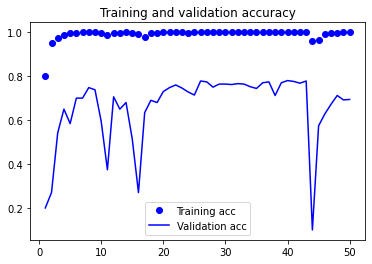

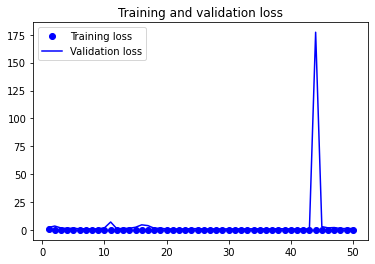

In [ ]:
graph_plots(resnet_History)

Acabou que nossa performance não foi nem perto do ideal nesse tipo de problema (perto de 77% de acurácia ainda pode ser um grande avanço em outros problemas, mas não aqui). O que aconteceu? Temos informações o suficiente para crer que, teoricamente, nossa abordagem com relação ao uso dos MFCCs está correta e apertar alguns parafusos da rede neural pode nos render alguns percentuais, mas não dará o salto que desejamos. Depois de algum tempo ajustando alguns parâmetros do método, sem resultado, decidimos dar alguns passos para trás e, após mais análises, descobrimos o que estava nos segurando: algo que nem sequer tinha passado por nossa cabeça.


----------

Turns out our performance was not even nearly the ideal in this kind of problem (near 77% accuracy can still be a huge step in other problems, but not in this one). What happened? We have enough information to believe that, theoretically, our approach in relation to the MFCC is correct and to tune a few hyperparameters would only give us a few accuracy points and not give us the performance hop we want. After a few time investigating, without any result, we gave a few steps back and, after more analysis, we finded out what was holding us: something that hasn't even going through our minds.

## Abrindo o MFCC e consertando nossos erros

----

## Looking inside the MFCC and fixing our errors

A nossa revelação, embora talvez seja algo óbvio para alguém mais experiente no assunto, veio quando "abrimos" o MFCC. Seja por que trabalhamos com imagens a mais de um ano, por redes convolucionais serem frequentemente associadas com a resolução de problemas visuais ou pelo uso de uma adaptação da ResNET, que surgiu para classificar imagens da base de dados ImageNet, nós nos contentamos com entender um pouco da teoria matemática por trás do cálculo dos MFCCs e não chegamos a olhar para os dados antes de transformá-los nos gráficos que já foram mostrados anteriormente nesse notebook. Vamos, então, olhar os dados que são utilizados para gerar a representação gráfica do MFCC.

-----

Our revelation may be obvios to someone who deals with audio problems more often, but it came when we "opened" the MFCC. Being it for working with images with over a year, because the convolutional networks being constantly associated to visual problems or for using a ResNet adaptation, a network that raises to solve the ImageNet competition, we were satisfied with just understanding a little of the mathematical theory behind the MFCC calculus and didn't looked well enough the data before transformating it to the graphics you already looked. Lets look, them, the data used to generate the MFCC graphic.

In [ ]:
def wav2mfcc(file_path, n_mfcc=20):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    y_filt = librosa.effects.preemphasis(wave, coef=0.97, zi=None, return_zf=False)
    mfcc = librosa.feature.mfcc(y=y_filt, sr=sr , n_mfcc=n_mfcc, dct_type=2, hop_length=(int)(0.01*sr), win_length=(int)(0.025*sr), window='hann', center=True)
    return mfcc

In [ ]:
mfcc = wav2mfcc(df['Pathing'][0])
print(mfcc)

[[-2.57574860e+02 -3.32464661e+02 -2.65682953e+02 -2.60460388e+02
  -2.64671173e+02 -2.75063843e+02 -2.81358002e+02 -2.79790039e+02
  -2.78024689e+02 -2.64802765e+02 -2.63471802e+02 -2.65023712e+02
  -2.78241150e+02 -2.87647644e+02 -3.10773499e+02 -3.64763824e+02
  -3.82378387e+02 -3.62913147e+02 -3.52145721e+02 -3.27034088e+02
  -3.14167297e+02 -3.07200378e+02 -3.16728333e+02 -3.14300262e+02
  -3.13819458e+02 -3.32540497e+02 -3.54457153e+02 -3.61695465e+02
  -3.77158691e+02 -3.81490753e+02]
 [-7.62401485e+00 -2.19070187e+01 -6.03557739e+01 -6.70716248e+01
  -7.27396393e+01 -8.20769958e+01 -7.65574722e+01 -7.59138336e+01
  -7.80470276e+01 -7.87334747e+01 -7.23633881e+01 -8.05976486e+01
  -7.56523361e+01 -7.96652298e+01 -5.37725372e+01 -3.68840523e+01
  -4.88217087e+01 -5.83823624e+01 -4.20837135e+01 -3.28207016e+01
  -2.60823498e+01 -8.66751099e+00  2.10881186e+00  9.30300331e+00
   1.99074421e+01  2.77023315e+01  3.07218704e+01  3.37534332e+01
   3.58774185e+01  5.43033104e+01]
 [-7.0

In [ ]:
mfcc.shape

(20, 30)

Ao ver o mfcc percebemos que, embora a versão gráfica e o vetor dentro do MFCC representem a mesma coisa, eles são gritantemente diferentes tanto em tamanho quanto no conteúdo. Enquanto o gráfico é uma imagem 148x48 pixeis, do tipo RGB e possui valores entre 0 e 255 em cada dimensão, o vetor gerado pela librosa tem tamanho 20(nº de coeficientes do mfcc) x o número de janelas avaliadas, que é 30 no caso particular em que mostramos, e não podemos afirmar com certeza o valor mínimo e máximo dessa representação.

Dito isso, enxergamos que o que estavamos fazendo pode ser comparado a tentar prever curvas cartesianas mas, ao invés de alimentar com os dados, colocar no modelo gráficos cartesianos. Vamos ver agora como nossa CNN vai performar com a representação original da librosa.

-----

When we looked the MFCC we realized that, although the graphical version and the MFCC vector represent the same thing, they are blatantly differents in size and values. While the graph is a 148x48 RGB image with values between 0 and 255 in the last dimension, the vector generated by the librosa library has a 20 (number of cepstral coefficients) x the number of windows analized, wich is 30 in the particular case we showed before and we can not precisely indicate the minimum value of this representation.

With that said, we saw that what we were doing was like trying to predict cartesian equations but, instead of feed with the equations, we was feeding the model with the curve graphs. Lets see how our CNN is going to perform with the librosa original representation.

## Usando o MFCC em vetor

-----

### Using the vector representation of the MFCC

### Pré-processamento

Outro problema da representação no gráfico era que, embora os áudios tenham tamanho diferentes, eles estavam representados em imagens do mesmo tamanho. Esse problema de disparidade nos tamanhos irá nos seguir para a representação vetorial, com uma diferença: dessa vez é impossível que ele passe despercebido, pois como cada áudio tem tamanho diferente, gerará vetores de tamanho diferentes como podemos ver a seguir:

---


### Pré-processing

Another issue of the graphical representation was that, even if the audios had different sized, they were represented in images of the same size. This representation problem will follow us to the vector one, with a difference> this time is impossible him to sneak bellow our noses because, since every audio has a different size, it will generate different sizes vector as we can see ahead:

In [ ]:
for i in df.head()['Pathing']:
  x = wav2mfcc(i)
  print(x.shape)

(20, 30)
(20, 60)
(20, 75)
(20, 46)
(20, 51)


O problema disso é que não podemos alimentar uma rede neural com vetores de tamanhos diferentes, e esses vetores tem tamanhos bem opostos: enquanto a maioria gera vetores de tamanho entre 40 e 70, os maiores podem chegar a 229.

Precisaremos então de um cropping, onde se  diminui a dimensão dos áudios cortando alguma parte, ou um padding, em que colocamos 0 no começo e fim dos vetores para que suas dimensões fiquem iguais. Embora tenhamos testado a segunda opção, transformando os vetores para a maior dimensão, decidimos colocar o tamanho dos vetores em 100. Fazemos isso com um padding nos vetores de dimensão menor que 100 e um cropping nos vetores maiores que isso. Embora essa abordagem pode deixar de fora alguma parte importante dos áudios mais longos, nós não sabemos o suficiente para ter certeza de pegar as partes mais importantes dos áudios.

Também estaremos adicionando uma dimensão, gerando vetores 20x100x1, para que a rede convolucional trabalhe de acordo.

----

The problem is that we can not feed a neural network with different sizes vectors, and this vector has very different sizes: while they are mostly between 40 and 70, the bigger ones can reach 229.

We will need, them, a cropping - where you decrease the audio dimensions cutting a few samples on the edges - or a padding - where you increase the size of the data putting zeros on the edges to match the bigger size. We tested the second option but we choose fixing the vectors size to one hundred. We pad the vectors with sizes less than 100 and we crop the bigger ones. This approach can leave behind some important parts of the bigger audios, but we do not know enough to be sure to keep the right part of the bigger data samples.

We will also add a dimension, generating 20x100x1 tridimensional vectors, because we are using 2D convolutional layers.

In [ ]:
#Função que gera o mfcc e faz o padding/cropping
#####################
#Function that generates the mfcc and do the padding/cropping

def cropwav2mfcc(file_path, max_pad_len=100, n_mfcc=20):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    y_filt = librosa.effects.preemphasis(wave, coef=0.97, zi=None, return_zf=False)
    mfcc = librosa.feature.mfcc(y=y_filt, sr=sr , n_mfcc=n_mfcc, dct_type=2, hop_length=(int)(0.01*sr), win_length=(int)(0.025*sr), window='hann', center=True)
    if (mfcc.shape[1] <= max_pad_len):
      pad_width = max_pad_len - mfcc.shape[1]
      mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
      crop_width = mfcc.shape[1] - max_pad_len
      mfcc = mfcc[:, crop_width//2:mfcc.shape[1]- crop_width//2]
      if ( (mfcc.shape[1] % 2) != 0 ):
        mfcc = mfcc[:, :-1]
    dim_1 = mfcc.shape[0]
    dim_2 = mfcc.shape[1]
    mfcc = mfcc.reshape(dim_1, dim_2, 1)
    return mfcc

Um teste simples

-----

A simple test

In [ ]:
#Você pode conferir todas as amostras substituindo "df.head()" por "df"
#You can look every sample replacing "df.head" with "df"

for i in df.head()['Pathing']:
  x = cropwav2mfcc(i)
  print(x.shape)

(20, 100, 1)
(20, 100, 1)
(20, 100, 1)
(20, 100, 1)
(20, 100, 1)


Agora que já resolvemos esse problema, podemos carregar os dados:

-----

Now we can load the data:

In [ ]:
# Carregando os mfccs
# Loading the mfccs

X = []
for i in df['Pathing']:
  x = cropwav2mfcc(i)
  X.append(x)
X = np.asarray(X)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1933
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1399
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1876
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1983
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2033
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1963
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

In [ ]:
# Carregando as classes (Em One Hot encoding)
# Loading the labels (In One Hot encoding)

lbl = LabelEncoder()
y = lbl.fit_transform(df[['digit']])
one_hot_y = to_categorical(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Dividindo entre conjunto de treino e validação

#Spliting between train and validation

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, one_hot_y, test_size=0.1, random_state=1)

Agora que já carregamos nossos MFCCs,  precisamos normalizá-los. Nós fizemos o teste e descobrimos que os valores nesses vetores variam de -919.2003 a 186.26495, algo longe de ser o ideal ou próximo para um modelo, especialmente em redes neurais, que preferem trabalhar com valores entre 0 e 1 ou -1 e 1.

Para fazer isso vamos utilizar um módulo da biblioteca scikit-learn, o Normalizer, que fará a normalização da forma correta: pegará os parâmetros da normalização do conjunto treino e aplicará os mesmos parâmetros no conjunto validação. Já que o Normalizer é feito para vetores unidimensionais, nós pegaremos esse conjunto de vetores, transformaremos ele em unidimensional, normalizaremos e revertermos a mudança de dimensão. 

A normalização talvez possa ser aplicada em cada coeficiente ou em cada janela de tempo analisada, mas mesmo os resultados empíricos de performance numa rede neural, já que nós interpretamos apenas o seu resultado, podem ser um caso de sorte e não o correto, e, como nós não somos profissionais do áudio para afirmar qual a melhor abordagem, fomos pela normalização total, a mais simples de se fazer. Caso alguém entendido do assunto saiba qual seria a forma mais correta de normalizar, por favor entre em contato para que o estudo seja o mais próximo possível do estado da arte.

Vamos normalizar nossos áudios:

-------

Now that we already loaded our MFFCs, we need to normalize them. We did the test and finded out that the values in these vectors fluctuate between -919.2003 to 186.26495, something way far than the ideal, especially if we are working with neural networks, technique that prefers working with values between 0 and 1 or -1 and 1.

To do that we will use a module of the scikit-learn library, o Normalizer, that will normalize correctly: it will take the test normalization params and apply the same ones in the validation set. Since the Normalizer is used to unidimensional vectors, we will turn our vector in unidimensionals ones, normalize them and turn back the dimensions.

The normalization can also been apply in each cepstral coefficient or in each window, but even the empirical performance results, since a neural network has no theoretical interpretation, can be luck and not the correct, we went through the total normalization, the simplest one. If someone that knows more than we about MFCCs know wich normalization technique is more correct, please contact us so we can approximate our study to an art.

Let's normalize our audios:


In [ ]:
from sklearn.preprocessing import Normalizer

x_train = train_data.reshape((train_data.shape[0], train_data.shape[1]*train_data.shape[2]))
x_val = test_data.reshape((test_data.shape[0], test_data.shape[1]*test_data.shape[2]))

transformer = Normalizer().fit(x_train)
x_train = transformer.transform(x_train)
x_val = transformer.transform(x_val)
x_train = x_train.reshape((x_train.shape[0], ) + X.shape[1:])
x_val = x_val.reshape((x_val.shape[0], ) + X.shape[1:])

### Construindo e executando o modelo

-----

###Building and running the model

In [ ]:
CResNet = build_CroppedResNET((20,100,1))

In [ ]:
CResNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 20, 100, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_33 (Conv2D)             (None, 10, 50, 64)   3200        ['image[0][0]']                  
                                                                                                  
 conv2d_34 (Conv2D)             (None, 10, 50, 64)   36928       ['conv2d_33[0][0]']              
                                                                                                  
 batch_normalization_32 (BatchN  (None, 10, 50, 64)  256         ['conv2d_34[0][0]']        

In [ ]:
CResNET_History = CResNet.fit(x= x_train,
                            y = train_labels,
                            epochs=50,
                            batch_size=32,
                            validation_data=(x_val, test_labels))

Epoch 1/50
85/85 [==============================] - 20s 76ms/step - loss: 0.6255 - acc: 0.8081 - val_loss: 3.1449 - val_acc: 0.0967
Epoch 2/50
85/85 [==============================] - 6s 68ms/step - loss: 0.1296 - acc: 0.9607 - val_loss: 3.0936 - val_acc: 0.1567
Epoch 3/50
85/85 [==============================] - 6s 68ms/step - loss: 0.0759 - acc: 0.9778 - val_loss: 3.7174 - val_acc: 0.1500
Epoch 4/50
85/85 [==============================] - 6s 68ms/step - loss: 0.0426 - acc: 0.9863 - val_loss: 3.7362 - val_acc: 0.1500
Epoch 5/50
85/85 [==============================] - 6s 70ms/step - loss: 0.0379 - acc: 0.9900 - val_loss: 1.8267 - val_acc: 0.3667
Epoch 6/50
85/85 [==============================] - 6s 68ms/step - loss: 0.0382 - acc: 0.9889 - val_loss: 0.4672 - val_acc: 0.8500
Epoch 7/50
85/85 [==============================] - 6s 69ms/step - loss: 0.0224 - acc: 0.9930 - val_loss: 0.1744 - val_acc: 0.9567
Epoch 8/50
85/85 [==============================] - 6s 68ms/step - loss: 0.0164 - 

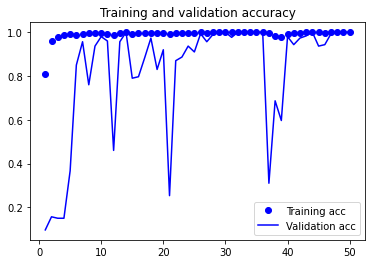

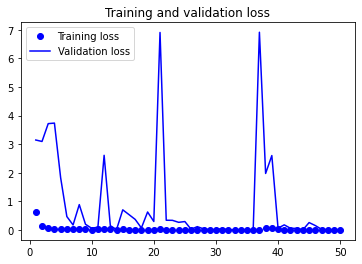

In [ ]:
#Grafico de perda e validação do modelo

graph_plots(CResNET_History)

Mesmo nossa rede sendo razoavelmente instável, ela chega a resultados extremamente satisfatórios e que fazem sentido, pois ao momento que a perda da rede é pequena, sua acurácia chega perto da perfeição.

Poderíamos facilmente chegar a conclusão que chegamos a um modelo quase perfeito e fazer apenas pequenos ajustes, como na função de ativação, número de _hidden layers_, estabilizar o modelo com uma callback de learning rate dinâmica, entre outras mudanças.

Porém, embora tenhamos feito a divisão treino teste total pois a maioria dos notebooks que achamos que trabalham com o FSDD o fazem, nós desde o começo não acreditávamos que essa divisão estava correta.

Voltemos a análise inicial do nosso dataset, em que contemplamos os seis locutores. Quando dividimos o total em treino e validação simplesmente por proporção de classes como faz o train-test-split do scikit-learn, nós colocamos amostras de cada falante em ambos o conjunto. Como isso pode ser um problema? O modelo conhecerá como George, por exemplo, fala o número um, e no conjunto para validar a rede será avaliado outro áudio de George falando o mesmo número. Mesmo que sejam áudios diferentes, a máquina já conhece como George fala o número um, sendo, de certa forma, uma repetição e um vício da rede.

Chegamos a conclusão, então, de que a melhor forma de dividir os conjuntos seria separar um locutor específico para validação, pois assim simularíamos uma nova entrada no conjunto de dados, com uma pessoa até então desconhecida pela CNN falando os áudios. Escolhemos inicalmente Jackson por não ser um falante de sotaque único (você pode conferir isso no arquivo de metadados do FSDD), pois Theo também é norte-americano, porém também iremos conferir como a rede performa com um sotaque desconhecido utilizando o único grego, George.

-------

Even with your network being somewhat unstable, it reachs to satisfying results that makes sense, since the lower the loss the bigger the accuracy.

We can easily reach the conclusion that we made a almost-perfect model and only do smalls adjustments on things like activation functions, number of hidden layer, dinamic learning rate callback and other smalls details.

However, besides our scikit-learn train-test split, the split that most FSDD notebooks uses, we didn't believe it was the correct division from the beggining.

Let's look back to the initial analysis, when we looked onto the 6 speakers. When we divided all the audio data into train and validation using only class balancing as the scikit-learn library do, we put audios from the same speaker in both sets. How can that be a problem? The model will know how George, for example, speaks the number one and in the validation set it will analyse another audio of George speaking the same number. Even though are different audios, the model already knows how George speaks the number one and that's an issue and a adulteration of the model real performance.

We reach, then, the conclusion that the best way of splitting the sets is to separate a specific speaker as the validation set, that way we would simulate a new entrance in the data set, with a unknown speaker. We choose Jackson because he's not an unique accent (you can look to that on  the FSDD metadata .json file), but we will look at the model performance with an unknown accent using the only Greek, George.

## Validando a rede com Jackson

----

## Validating the network with Jackson

In [ ]:
df_train = df.query("Speaker != 'jackson'")
df_val = df.query("Speaker == 'jackson'")
df_val = df_val.copy()
df_val.reset_index(drop=True, inplace=True)
df_train = df_train.copy()
df_train.reset_index(drop=True, inplace=True)
lbl = LabelEncoder()
y_train = lbl.fit_transform(df_train[['digit']])
y_val = lbl.fit_transform(df_val[['digit']])
one_hot_y_train = to_categorical(y_train)
one_hot_y_val = to_categorical(y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_train = []
for i in df_train['Pathing']:
  x = cropwav2mfcc(i)
  print(i)
  X_train.append(x)

free-spoken-digit-dataset/recordings/0_george_0.wav
free-spoken-digit-dataset/recordings/0_george_1.wav
free-spoken-digit-dataset/recordings/0_george_10.wav
free-spoken-digit-dataset/recordings/0_george_11.wav
free-spoken-digit-dataset/recordings/0_george_12.wav
free-spoken-digit-dataset/recordings/0_george_13.wav
free-spoken-digit-dataset/recordings/0_george_14.wav
free-spoken-digit-dataset/recordings/0_george_15.wav
free-spoken-digit-dataset/recordings/0_george_16.wav
free-spoken-digit-dataset/recordings/0_george_17.wav
free-spoken-digit-dataset/recordings/0_george_18.wav
free-spoken-digit-dataset/recordings/0_george_19.wav
free-spoken-digit-dataset/recordings/0_george_2.wav
free-spoken-digit-dataset/recordings/0_george_20.wav
free-spoken-digit-dataset/recordings/0_george_21.wav
free-spoken-digit-dataset/recordings/0_george_22.wav
free-spoken-digit-dataset/recordings/0_george_23.wav
free-spoken-digit-dataset/recordings/0_george_24.wav
free-spoken-digit-dataset/recordings/0_george_25.

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1933
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1399
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1876
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_george_42.wav
free-spoken-digit-dataset/recordings/1_george_43.wav
free-spoken-digit-dataset/recordings/1_george_44.wav
free-spoken-digit-dataset/recordings/1_george_45.wav
free-spoken-digit-dataset/recordings/1_george_46.wav
free-spoken-digit-dataset/recordings/1_george_47.wav
free-spoken-digit-dataset/recordings/1_george_48.wav
free-spoken-digit-dataset/recordings/1_george_49.wav
free-spoken-digit-dataset/recordings/1_george_5.wav
free-spoken-digit-dataset/recordings/1_george_6.wav
free-spoken-digit-dataset/recordings/1_george_7.wav
free-spoken-digit-dataset/recordings/1_george_8.wav
free-spoken-digit-dataset/recordings/1_george_9.wav
free-spoken-digit-dataset/recordings/1_lucas_0.wav
free-spoken-digit-dataset/recordings/1_lucas_1.wav
free-spoken-digit-dataset/recordings/1_lucas_10.wav
free-spoken-digit-dataset/recordings/1_lucas_11.wav
free-spoken-digit-dataset/recordings/1_lucas_12.wav
free-spoken-digit-dataset/recordings/1_lucas_13.wav
free-s

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1983
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_lucas_30.wav
free-spoken-digit-dataset/recordings/1_lucas_31.wav
free-spoken-digit-dataset/recordings/1_lucas_32.wav
free-spoken-digit-dataset/recordings/1_lucas_33.wav
free-spoken-digit-dataset/recordings/1_lucas_34.wav
free-spoken-digit-dataset/recordings/1_lucas_35.wav
free-spoken-digit-dataset/recordings/1_lucas_36.wav
free-spoken-digit-dataset/recordings/1_lucas_37.wav
free-spoken-digit-dataset/recordings/1_lucas_38.wav
free-spoken-digit-dataset/recordings/1_lucas_39.wav
free-spoken-digit-dataset/recordings/1_lucas_4.wav
free-spoken-digit-dataset/recordings/1_lucas_40.wav
free-spoken-digit-dataset/recordings/1_lucas_41.wav
free-spoken-digit-dataset/recordings/1_lucas_42.wav
free-spoken-digit-dataset/recordings/1_lucas_43.wav
free-spoken-digit-dataset/recordings/1_lucas_44.wav
free-spoken-digit-dataset/recordings/1_lucas_45.wav
free-spoken-digit-dataset/recordings/1_lucas_46.wav
free-spoken-digit-dataset/recordings/1_lucas_47.wav
free-spoken-d

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2033
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1963
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2007
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_nicolas_20.wav
free-spoken-digit-dataset/recordings/1_nicolas_21.wav
free-spoken-digit-dataset/recordings/1_nicolas_22.wav
free-spoken-digit-dataset/recordings/1_nicolas_23.wav
free-spoken-digit-dataset/recordings/1_nicolas_24.wav
free-spoken-digit-dataset/recordings/1_nicolas_25.wav
free-spoken-digit-dataset/recordings/1_nicolas_26.wav
free-spoken-digit-dataset/recordings/1_nicolas_27.wav
free-spoken-digit-dataset/recordings/1_nicolas_28.wav
free-spoken-digit-dataset/recordings/1_nicolas_29.wav
free-spoken-digit-dataset/recordings/1_nicolas_3.wav
free-spoken-digit-dataset/recordings/1_nicolas_30.wav
free-spoken-digit-dataset/recordings/1_nicolas_31.wav
free-spoken-digit-dataset/recordings/1_nicolas_32.wav
free-spoken-digit-dataset/recordings/1_nicolas_33.wav
free-spoken-digit-dataset/recordings/1_nicolas_34.wav
free-spoken-digit-dataset/recordings/1_nicolas_35.wav
free-spoken-digit-dataset/recordings/1_nicolas_36.wav
free-spoken-digit-dataset/rec

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1976
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1987
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1886
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1842
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1753
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1870
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/1_theo_11.wav
free-spoken-digit-dataset/recordings/1_theo_12.wav
free-spoken-digit-dataset/recordings/1_theo_13.wav
free-spoken-digit-dataset/recordings/1_theo_14.wav
free-spoken-digit-dataset/recordings/1_theo_15.wav
free-spoken-digit-dataset/recordings/1_theo_16.wav
free-spoken-digit-dataset/recordings/1_theo_17.wav
free-spoken-digit-dataset/recordings/1_theo_18.wav
free-spoken-digit-dataset/recordings/1_theo_19.wav
free-spoken-digit-dataset/recordings/1_theo_2.wav
free-spoken-digit-dataset/recordings/1_theo_20.wav
free-spoken-digit-dataset/recordings/1_theo_21.wav
free-spoken-digit-dataset/recordings/1_theo_22.wav
free-spoken-digit-dataset/recordings/1_theo_23.wav
free-spoken-digit-dataset/recordings/1_theo_24.wav
free-spoken-digit-dataset/recordings/1_theo_25.wav
free-spoken-digit-dataset/recordings/1_theo_26.wav
free-spoken-digit-dataset/recordings/1_theo_27.wav
free-spoken-digit-dataset/recordings/1_theo_28.wav
free-spoken-digit-dataset/record

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1997
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_theo_30.wav
free-spoken-digit-dataset/recordings/1_theo_31.wav
free-spoken-digit-dataset/recordings/1_theo_32.wav
free-spoken-digit-dataset/recordings/1_theo_33.wav
free-spoken-digit-dataset/recordings/1_theo_34.wav
free-spoken-digit-dataset/recordings/1_theo_35.wav
free-spoken-digit-dataset/recordings/1_theo_36.wav
free-spoken-digit-dataset/recordings/1_theo_37.wav
free-spoken-digit-dataset/recordings/1_theo_38.wav
free-spoken-digit-dataset/recordings/1_theo_39.wav
free-spoken-digit-dataset/recordings/1_theo_4.wav
free-spoken-digit-dataset/recordings/1_theo_40.wav
free-spoken-digit-dataset/recordings/1_theo_41.wav
free-spoken-digit-dataset/recordings/1_theo_42.wav
free-spoken-digit-dataset/recordings/1_theo_43.wav
free-spoken-digit-dataset/recordings/1_theo_44.wav
free-spoken-digit-dataset/recordings/1_theo_45.wav
free-spoken-digit-dataset/recordings/1_theo_46.wav
free-spoken-digit-dataset/recordings/1_theo_47.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1720
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1692
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1565
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1737
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1890
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/1_theo_48.wav
free-spoken-digit-dataset/recordings/1_theo_49.wav
free-spoken-digit-dataset/recordings/1_theo_5.wav
free-spoken-digit-dataset/recordings/1_theo_6.wav
free-spoken-digit-dataset/recordings/1_theo_7.wav
free-spoken-digit-dataset/recordings/1_theo_8.wav
free-spoken-digit-dataset/recordings/1_theo_9.wav
free-spoken-digit-dataset/recordings/1_yweweler_0.wav
free-spoken-digit-dataset/recordings/1_yweweler_1.wav
free-spoken-digit-dataset/recordings/1_yweweler_10.wav
free-spoken-digit-dataset/recordings/1_yweweler_11.wav
free-spoken-digit-dataset/recordings/1_yweweler_12.wav
free-spoken-digit-dataset/recordings/1_yweweler_13.wav
free-spoken-digit-dataset/recordings/1_yweweler_14.wav
free-spoken-digit-dataset/recordings/1_yweweler_15.wav
free-spoken-digit-dataset/recordings/1_yweweler_16.wav
free-spoken-digit-dataset/recordings/1_yweweler_17.wav
free-spoken-digit-dataset/recordings/1_yweweler_18.wav
free-spoken-digit-dataset/recordings/1_ywewel

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2016
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_yweweler_36.wav
free-spoken-digit-dataset/recordings/1_yweweler_37.wav
free-spoken-digit-dataset/recordings/1_yweweler_38.wav
free-spoken-digit-dataset/recordings/1_yweweler_39.wav
free-spoken-digit-dataset/recordings/1_yweweler_4.wav
free-spoken-digit-dataset/recordings/1_yweweler_40.wav
free-spoken-digit-dataset/recordings/1_yweweler_41.wav
free-spoken-digit-dataset/recordings/1_yweweler_42.wav
free-spoken-digit-dataset/recordings/1_yweweler_43.wav
free-spoken-digit-dataset/recordings/1_yweweler_44.wav
free-spoken-digit-dataset/recordings/1_yweweler_45.wav
free-spoken-digit-dataset/recordings/1_yweweler_46.wav
free-spoken-digit-dataset/recordings/1_yweweler_47.wav
free-spoken-digit-dataset/recordings/1_yweweler_48.wav
free-spoken-digit-dataset/recordings/1_yweweler_49.wav
free-spoken-digit-dataset/recordings/1_yweweler_5.wav
free-spoken-digit-dataset/recordings/1_yweweler_6.wav
free-spoken-digit-dataset/recordings/1_yweweler_7.wav
free-spoken-di

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1932
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2035
  n_fft, y.shape[-1]



free-spoken-digit-dataset/recordings/2_george_47.wav
free-spoken-digit-dataset/recordings/2_george_48.wav
free-spoken-digit-dataset/recordings/2_george_49.wav
free-spoken-digit-dataset/recordings/2_george_5.wav
free-spoken-digit-dataset/recordings/2_george_6.wav
free-spoken-digit-dataset/recordings/2_george_7.wav
free-spoken-digit-dataset/recordings/2_george_8.wav
free-spoken-digit-dataset/recordings/2_george_9.wav
free-spoken-digit-dataset/recordings/2_lucas_0.wav
free-spoken-digit-dataset/recordings/2_lucas_1.wav
free-spoken-digit-dataset/recordings/2_lucas_10.wav
free-spoken-digit-dataset/recordings/2_lucas_11.wav
free-spoken-digit-dataset/recordings/2_lucas_12.wav
free-spoken-digit-dataset/recordings/2_lucas_13.wav
free-spoken-digit-dataset/recordings/2_lucas_14.wav
free-spoken-digit-dataset/recordings/2_lucas_15.wav
free-spoken-digit-dataset/recordings/2_lucas_16.wav
free-spoken-digit-dataset/recordings/2_lucas_17.wav
free-spoken-digit-dataset/recordings/2_lucas_18.wav
free-spoke

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1493
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1525
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1742
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1866
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1914
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1568
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/2_nicolas_24.wav
free-spoken-digit-dataset/recordings/2_nicolas_25.wav
free-spoken-digit-dataset/recordings/2_nicolas_26.wav
free-spoken-digit-dataset/recordings/2_nicolas_27.wav
free-spoken-digit-dataset/recordings/2_nicolas_28.wav
free-spoken-digit-dataset/recordings/2_nicolas_29.wav
free-spoken-digit-dataset/recordings/2_nicolas_3.wav
free-spoken-digit-dataset/recordings/2_nicolas_30.wav
free-spoken-digit-dataset/recordings/2_nicolas_31.wav
free-spoken-digit-dataset/recordings/2_nicolas_32.wav
free-spoken-digit-dataset/recordings/2_nicolas_33.wav
free-spoken-digit-dataset/recordings/2_nicolas_34.wav
free-spoken-digit-dataset/recordings/2_nicolas_35.wav
free-spoken-digit-dataset/recordings/2_nicolas_36.wav
free-spoken-digit-dataset/recordings/2_nicolas_37.wav
free-spoken-digit-dataset/recordings/2_nicolas_38.wav
free-spoken-digit-dataset/recordings/2_nicolas_39.wav
free-spoken-digit-dataset/recordings/2_nicolas_4.wav
free-spoken-digit-dataset/reco

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1475
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1852
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1953
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1819
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1664
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1962
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/2_theo_17.wav
free-spoken-digit-dataset/recordings/2_theo_18.wav
free-spoken-digit-dataset/recordings/2_theo_19.wav
free-spoken-digit-dataset/recordings/2_theo_2.wav
free-spoken-digit-dataset/recordings/2_theo_20.wav
free-spoken-digit-dataset/recordings/2_theo_21.wav
free-spoken-digit-dataset/recordings/2_theo_22.wav
free-spoken-digit-dataset/recordings/2_theo_23.wav
free-spoken-digit-dataset/recordings/2_theo_24.wav
free-spoken-digit-dataset/recordings/2_theo_25.wav
free-spoken-digit-dataset/recordings/2_theo_26.wav
free-spoken-digit-dataset/recordings/2_theo_27.wav
free-spoken-digit-dataset/recordings/2_theo_28.wav
free-spoken-digit-dataset/recordings/2_theo_29.wav
free-spoken-digit-dataset/recordings/2_theo_3.wav
free-spoken-digit-dataset/recordings/2_theo_30.wav
free-spoken-digit-dataset/recordings/2_theo_31.wav
free-spoken-digit-dataset/recordings/2_theo_32.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1601
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1288
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1854
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1807
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1704
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/2_theo_33.wav
free-spoken-digit-dataset/recordings/2_theo_34.wav
free-spoken-digit-dataset/recordings/2_theo_35.wav
free-spoken-digit-dataset/recordings/2_theo_36.wav
free-spoken-digit-dataset/recordings/2_theo_37.wav
free-spoken-digit-dataset/recordings/2_theo_38.wav
free-spoken-digit-dataset/recordings/2_theo_39.wav
free-spoken-digit-dataset/recordings/2_theo_4.wav
free-spoken-digit-dataset/recordings/2_theo_40.wav
free-spoken-digit-dataset/recordings/2_theo_41.wav
free-spoken-digit-dataset/recordings/2_theo_42.wav
free-spoken-digit-dataset/recordings/2_theo_43.wav
free-spoken-digit-dataset/recordings/2_theo_44.wav
free-spoken-digit-dataset/recordings/2_theo_45.wav
free-spoken-digit-dataset/recordings/2_theo_46.wav
free-spoken-digit-dataset/recordings/2_theo_47.wav
free-spoken-digit-dataset/recordings/2_theo_48.wav
free-spoken-digit-dataset/recordings/2_theo_49.wav
free-spoken-digit-dataset/recordings/2_theo_5.wav
free-spoken-digit-dataset/recordi

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2042
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2037
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1943
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2027
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1906
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/2_theo_8.wav
free-spoken-digit-dataset/recordings/2_theo_9.wav
free-spoken-digit-dataset/recordings/2_yweweler_0.wav
free-spoken-digit-dataset/recordings/2_yweweler_1.wav
free-spoken-digit-dataset/recordings/2_yweweler_10.wav
free-spoken-digit-dataset/recordings/2_yweweler_11.wav
free-spoken-digit-dataset/recordings/2_yweweler_12.wav
free-spoken-digit-dataset/recordings/2_yweweler_13.wav
free-spoken-digit-dataset/recordings/2_yweweler_14.wav
free-spoken-digit-dataset/recordings/2_yweweler_15.wav
free-spoken-digit-dataset/recordings/2_yweweler_16.wav
free-spoken-digit-dataset/recordings/2_yweweler_17.wav
free-spoken-digit-dataset/recordings/2_yweweler_18.wav
free-spoken-digit-dataset/recordings/2_yweweler_19.wav
free-spoken-digit-dataset/recordings/2_yweweler_2.wav
free-spoken-digit-dataset/recordings/2_yweweler_20.wav
free-spoken-digit-dataset/recordings/2_yweweler_21.wav
free-spoken-digit-dataset/recordings/2_yweweler_22.wav
free-spoken-digit-datas

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1900
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/2_yweweler_42.wav
free-spoken-digit-dataset/recordings/2_yweweler_43.wav
free-spoken-digit-dataset/recordings/2_yweweler_44.wav
free-spoken-digit-dataset/recordings/2_yweweler_45.wav
free-spoken-digit-dataset/recordings/2_yweweler_46.wav
free-spoken-digit-dataset/recordings/2_yweweler_47.wav
free-spoken-digit-dataset/recordings/2_yweweler_48.wav
free-spoken-digit-dataset/recordings/2_yweweler_49.wav
free-spoken-digit-dataset/recordings/2_yweweler_5.wav
free-spoken-digit-dataset/recordings/2_yweweler_6.wav
free-spoken-digit-dataset/recordings/2_yweweler_7.wav
free-spoken-digit-dataset/recordings/2_yweweler_8.wav
free-spoken-digit-dataset/recordings/2_yweweler_9.wav
free-spoken-digit-dataset/recordings/3_george_0.wav
free-spoken-digit-dataset/recordings/3_george_1.wav
free-spoken-digit-dataset/recordings/3_george_10.wav
free-spoken-digit-dataset/recordings/3_george_11.wav
free-spoken-digit-dataset/recordings/3_george_12.wav
free-spoken-digit-dataset/r

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2034
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1973
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_george_14.wav
free-spoken-digit-dataset/recordings/3_george_15.wav
free-spoken-digit-dataset/recordings/3_george_16.wav
free-spoken-digit-dataset/recordings/3_george_17.wav
free-spoken-digit-dataset/recordings/3_george_18.wav
free-spoken-digit-dataset/recordings/3_george_19.wav
free-spoken-digit-dataset/recordings/3_george_2.wav
free-spoken-digit-dataset/recordings/3_george_20.wav
free-spoken-digit-dataset/recordings/3_george_21.wav
free-spoken-digit-dataset/recordings/3_george_22.wav
free-spoken-digit-dataset/recordings/3_george_23.wav
free-spoken-digit-dataset/recordings/3_george_24.wav
free-spoken-digit-dataset/recordings/3_george_25.wav
free-spoken-digit-dataset/recordings/3_george_26.wav
free-spoken-digit-dataset/recordings/3_george_27.wav
free-spoken-digit-dataset/recordings/3_george_28.wav
free-spoken-digit-dataset/recordings/3_george_29.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1531
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_george_3.wav
free-spoken-digit-dataset/recordings/3_george_30.wav
free-spoken-digit-dataset/recordings/3_george_31.wav
free-spoken-digit-dataset/recordings/3_george_32.wav
free-spoken-digit-dataset/recordings/3_george_33.wav
free-spoken-digit-dataset/recordings/3_george_34.wav
free-spoken-digit-dataset/recordings/3_george_35.wav
free-spoken-digit-dataset/recordings/3_george_36.wav
free-spoken-digit-dataset/recordings/3_george_37.wav
free-spoken-digit-dataset/recordings/3_george_38.wav
free-spoken-digit-dataset/recordings/3_george_39.wav
free-spoken-digit-dataset/recordings/3_george_4.wav
free-spoken-digit-dataset/recordings/3_george_40.wav
free-spoken-digit-dataset/recordings/3_george_41.wav
free-spoken-digit-dataset/recordings/3_george_42.wav
free-spoken-digit-dataset/recordings/3_george_43.wav
free-spoken-digit-dataset/recordings/3_george_44.wav
free-spoken-digit-dataset/recordings/3_george_45.wav
free-spoken-digit-dataset/recordings/3_george_46

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1541
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_george_49.wav
free-spoken-digit-dataset/recordings/3_george_5.wav
free-spoken-digit-dataset/recordings/3_george_6.wav
free-spoken-digit-dataset/recordings/3_george_7.wav
free-spoken-digit-dataset/recordings/3_george_8.wav
free-spoken-digit-dataset/recordings/3_george_9.wav
free-spoken-digit-dataset/recordings/3_lucas_0.wav
free-spoken-digit-dataset/recordings/3_lucas_1.wav
free-spoken-digit-dataset/recordings/3_lucas_10.wav
free-spoken-digit-dataset/recordings/3_lucas_11.wav
free-spoken-digit-dataset/recordings/3_lucas_12.wav
free-spoken-digit-dataset/recordings/3_lucas_13.wav
free-spoken-digit-dataset/recordings/3_lucas_14.wav
free-spoken-digit-dataset/recordings/3_lucas_15.wav
free-spoken-digit-dataset/recordings/3_lucas_16.wav
free-spoken-digit-dataset/recordings/3_lucas_17.wav
free-spoken-digit-dataset/recordings/3_lucas_18.wav
free-spoken-digit-dataset/recordings/3_lucas_19.wav
free-spoken-digit-dataset/recordings/3_lucas_2.wav
free-spoken-di

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1640
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1547
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1516
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1609
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1455
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1650
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/3_nicolas_27.wav
free-spoken-digit-dataset/recordings/3_nicolas_28.wav
free-spoken-digit-dataset/recordings/3_nicolas_29.wav
free-spoken-digit-dataset/recordings/3_nicolas_3.wav
free-spoken-digit-dataset/recordings/3_nicolas_30.wav
free-spoken-digit-dataset/recordings/3_nicolas_31.wav
free-spoken-digit-dataset/recordings/3_nicolas_32.wav
free-spoken-digit-dataset/recordings/3_nicolas_33.wav
free-spoken-digit-dataset/recordings/3_nicolas_34.wav
free-spoken-digit-dataset/recordings/3_nicolas_35.wav
free-spoken-digit-dataset/recordings/3_nicolas_36.wav
free-spoken-digit-dataset/recordings/3_nicolas_37.wav
free-spoken-digit-dataset/recordings/3_nicolas_38.wav
free-spoken-digit-dataset/recordings/3_nicolas_39.wav
free-spoken-digit-dataset/recordings/3_nicolas_4.wav
free-spoken-digit-dataset/recordings/3_nicolas_40.wav
free-spoken-digit-dataset/recordings/3_nicolas_41.wav
free-spoken-digit-dataset/recordings/3_nicolas_42.wav
free-spoken-digit-dataset/reco

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1805
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1713
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2023
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1915
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_nicolas_47.wav
free-spoken-digit-dataset/recordings/3_nicolas_48.wav
free-spoken-digit-dataset/recordings/3_nicolas_49.wav
free-spoken-digit-dataset/recordings/3_nicolas_5.wav
free-spoken-digit-dataset/recordings/3_nicolas_6.wav
free-spoken-digit-dataset/recordings/3_nicolas_7.wav
free-spoken-digit-dataset/recordings/3_nicolas_8.wav
free-spoken-digit-dataset/recordings/3_nicolas_9.wav
free-spoken-digit-dataset/recordings/3_theo_0.wav
free-spoken-digit-dataset/recordings/3_theo_1.wav
free-spoken-digit-dataset/recordings/3_theo_10.wav
free-spoken-digit-dataset/recordings/3_theo_11.wav
free-spoken-digit-dataset/recordings/3_theo_12.wav
free-spoken-digit-dataset/recordings/3_theo_13.wav
free-spoken-digit-dataset/recordings/3_theo_14.wav
free-spoken-digit-dataset/recordings/3_theo_15.wav
free-spoken-digit-dataset/recordings/3_theo_16.wav
free-spoken-digit-dataset/recordings/3_theo_17.wav
free-spoken-digit-dataset/recordings/3_theo_18.wav
free-spoken-di

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1931
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1793
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1824
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1579
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1817
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_theo_21.wav
free-spoken-digit-dataset/recordings/3_theo_22.wav
free-spoken-digit-dataset/recordings/3_theo_23.wav
free-spoken-digit-dataset/recordings/3_theo_24.wav
free-spoken-digit-dataset/recordings/3_theo_25.wav
free-spoken-digit-dataset/recordings/3_theo_26.wav
free-spoken-digit-dataset/recordings/3_theo_27.wav
free-spoken-digit-dataset/recordings/3_theo_28.wav
free-spoken-digit-dataset/recordings/3_theo_29.wav
free-spoken-digit-dataset/recordings/3_theo_3.wav
free-spoken-digit-dataset/recordings/3_theo_30.wav
free-spoken-digit-dataset/recordings/3_theo_31.wav
free-spoken-digit-dataset/recordings/3_theo_32.wav
free-spoken-digit-dataset/recordings/3_theo_33.wav
free-spoken-digit-dataset/recordings/3_theo_34.wav
free-spoken-digit-dataset/recordings/3_theo_35.wav
free-spoken-digit-dataset/recordings/3_theo_36.wav
free-spoken-digit-dataset/recordings/3_theo_37.wav
free-spoken-digit-dataset/recordings/3_theo_38.wav
free-spoken-digit-dataset/record

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1958
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1795
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2036
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1846
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_theo_40.wav
free-spoken-digit-dataset/recordings/3_theo_41.wav
free-spoken-digit-dataset/recordings/3_theo_42.wav
free-spoken-digit-dataset/recordings/3_theo_43.wav
free-spoken-digit-dataset/recordings/3_theo_44.wav
free-spoken-digit-dataset/recordings/3_theo_45.wav
free-spoken-digit-dataset/recordings/3_theo_46.wav
free-spoken-digit-dataset/recordings/3_theo_47.wav
free-spoken-digit-dataset/recordings/3_theo_48.wav
free-spoken-digit-dataset/recordings/3_theo_49.wav
free-spoken-digit-dataset/recordings/3_theo_5.wav
free-spoken-digit-dataset/recordings/3_theo_6.wav
free-spoken-digit-dataset/recordings/3_theo_7.wav
free-spoken-digit-dataset/recordings/3_theo_8.wav
free-spoken-digit-dataset/recordings/3_theo_9.wav
free-spoken-digit-dataset/recordings/3_yweweler_0.wav
free-spoken-digit-dataset/recordings/3_yweweler_1.wav
free-spoken-digit-dataset/recordings/3_yweweler_10.wav
free-spoken-digit-dataset/recordings/3_yweweler_11.wav
free-spoken-digit-data

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1803
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1945
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2001
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1892
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2005
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_yweweler_14.wav
free-spoken-digit-dataset/recordings/3_yweweler_15.wav
free-spoken-digit-dataset/recordings/3_yweweler_16.wav
free-spoken-digit-dataset/recordings/3_yweweler_17.wav
free-spoken-digit-dataset/recordings/3_yweweler_18.wav
free-spoken-digit-dataset/recordings/3_yweweler_19.wav
free-spoken-digit-dataset/recordings/3_yweweler_2.wav
free-spoken-digit-dataset/recordings/3_yweweler_20.wav
free-spoken-digit-dataset/recordings/3_yweweler_21.wav
free-spoken-digit-dataset/recordings/3_yweweler_22.wav
free-spoken-digit-dataset/recordings/3_yweweler_23.wav
free-spoken-digit-dataset/recordings/3_yweweler_24.wav
free-spoken-digit-dataset/recordings/3_yweweler_25.wav
free-spoken-digit-dataset/recordings/3_yweweler_26.wav
free-spoken-digit-dataset/recordings/3_yweweler_27.wav
free-spoken-digit-dataset/recordings/3_yweweler_28.wav
free-spoken-digit-dataset/recordings/3_yweweler_29.wav
free-spoken-digit-dataset/recordings/3_yweweler_3.wav
free-spoken-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1697
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1903
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_yweweler_31.wav
free-spoken-digit-dataset/recordings/3_yweweler_32.wav
free-spoken-digit-dataset/recordings/3_yweweler_33.wav
free-spoken-digit-dataset/recordings/3_yweweler_34.wav
free-spoken-digit-dataset/recordings/3_yweweler_35.wav
free-spoken-digit-dataset/recordings/3_yweweler_36.wav
free-spoken-digit-dataset/recordings/3_yweweler_37.wav
free-spoken-digit-dataset/recordings/3_yweweler_38.wav
free-spoken-digit-dataset/recordings/3_yweweler_39.wav
free-spoken-digit-dataset/recordings/3_yweweler_4.wav
free-spoken-digit-dataset/recordings/3_yweweler_40.wav
free-spoken-digit-dataset/recordings/3_yweweler_41.wav
free-spoken-digit-dataset/recordings/3_yweweler_42.wav
free-spoken-digit-dataset/recordings/3_yweweler_43.wav
free-spoken-digit-dataset/recordings/3_yweweler_44.wav
free-spoken-digit-dataset/recordings/3_yweweler_45.wav
free-spoken-digit-dataset/recordings/3_yweweler_46.wav
free-spoken-digit-dataset/recordings/3_yweweler_47.wav
free-spoken

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1919
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_george_22.wav
free-spoken-digit-dataset/recordings/4_george_23.wav
free-spoken-digit-dataset/recordings/4_george_24.wav
free-spoken-digit-dataset/recordings/4_george_25.wav
free-spoken-digit-dataset/recordings/4_george_26.wav
free-spoken-digit-dataset/recordings/4_george_27.wav
free-spoken-digit-dataset/recordings/4_george_28.wav
free-spoken-digit-dataset/recordings/4_george_29.wav
free-spoken-digit-dataset/recordings/4_george_3.wav
free-spoken-digit-dataset/recordings/4_george_30.wav
free-spoken-digit-dataset/recordings/4_george_31.wav
free-spoken-digit-dataset/recordings/4_george_32.wav
free-spoken-digit-dataset/recordings/4_george_33.wav
free-spoken-digit-dataset/recordings/4_george_34.wav
free-spoken-digit-dataset/recordings/4_george_35.wav
free-spoken-digit-dataset/recordings/4_george_36.wav
free-spoken-digit-dataset/recordings/4_george_37.wav
free-spoken-digit-dataset/recordings/4_george_38.wav
free-spoken-digit-dataset/recordings/4_george_3

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1832
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_nicolas_36.wav
free-spoken-digit-dataset/recordings/4_nicolas_37.wav
free-spoken-digit-dataset/recordings/4_nicolas_38.wav
free-spoken-digit-dataset/recordings/4_nicolas_39.wav
free-spoken-digit-dataset/recordings/4_nicolas_4.wav
free-spoken-digit-dataset/recordings/4_nicolas_40.wav
free-spoken-digit-dataset/recordings/4_nicolas_41.wav
free-spoken-digit-dataset/recordings/4_nicolas_42.wav
free-spoken-digit-dataset/recordings/4_nicolas_43.wav
free-spoken-digit-dataset/recordings/4_nicolas_44.wav
free-spoken-digit-dataset/recordings/4_nicolas_45.wav
free-spoken-digit-dataset/recordings/4_nicolas_46.wav
free-spoken-digit-dataset/recordings/4_nicolas_47.wav
free-spoken-digit-dataset/recordings/4_nicolas_48.wav
free-spoken-digit-dataset/recordings/4_nicolas_49.wav
free-spoken-digit-dataset/recordings/4_nicolas_5.wav
free-spoken-digit-dataset/recordings/4_nicolas_6.wav
free-spoken-digit-dataset/recordings/4_nicolas_7.wav
free-spoken-digit-dataset/record

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2039
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1873
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1632
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1806
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2022
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_theo_1.wav
free-spoken-digit-dataset/recordings/4_theo_10.wav
free-spoken-digit-dataset/recordings/4_theo_11.wav
free-spoken-digit-dataset/recordings/4_theo_12.wav
free-spoken-digit-dataset/recordings/4_theo_13.wav
free-spoken-digit-dataset/recordings/4_theo_14.wav
free-spoken-digit-dataset/recordings/4_theo_15.wav
free-spoken-digit-dataset/recordings/4_theo_16.wav
free-spoken-digit-dataset/recordings/4_theo_17.wav
free-spoken-digit-dataset/recordings/4_theo_18.wav
free-spoken-digit-dataset/recordings/4_theo_19.wav
free-spoken-digit-dataset/recordings/4_theo_2.wav
free-spoken-digit-dataset/recordings/4_theo_20.wav
free-spoken-digit-dataset/recordings/4_theo_21.wav
free-spoken-digit-dataset/recordings/4_theo_22.wav
free-spoken-digit-dataset/recordings/4_theo_23.wav
free-spoken-digit-dataset/recordings/4_theo_24.wav
free-spoken-digit-dataset/recordings/4_theo_25.wav
free-spoken-digit-dataset/recordings/4_theo_26.wav
free-spoken-digit-dataset/recordi

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2014
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2045
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_theo_47.wav
free-spoken-digit-dataset/recordings/4_theo_48.wav
free-spoken-digit-dataset/recordings/4_theo_49.wav
free-spoken-digit-dataset/recordings/4_theo_5.wav
free-spoken-digit-dataset/recordings/4_theo_6.wav
free-spoken-digit-dataset/recordings/4_theo_7.wav
free-spoken-digit-dataset/recordings/4_theo_8.wav
free-spoken-digit-dataset/recordings/4_theo_9.wav
free-spoken-digit-dataset/recordings/4_yweweler_0.wav
free-spoken-digit-dataset/recordings/4_yweweler_1.wav
free-spoken-digit-dataset/recordings/4_yweweler_10.wav
free-spoken-digit-dataset/recordings/4_yweweler_11.wav
free-spoken-digit-dataset/recordings/4_yweweler_12.wav
free-spoken-digit-dataset/recordings/4_yweweler_13.wav
free-spoken-digit-dataset/recordings/4_yweweler_14.wav
free-spoken-digit-dataset/recordings/4_yweweler_15.wav
free-spoken-digit-dataset/recordings/4_yweweler_16.wav
free-spoken-digit-dataset/recordings/4_yweweler_17.wav
free-spoken-digit-dataset/recordings/4_yweweler_1

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1790
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1705
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_yweweler_20.wav
free-spoken-digit-dataset/recordings/4_yweweler_21.wav
free-spoken-digit-dataset/recordings/4_yweweler_22.wav
free-spoken-digit-dataset/recordings/4_yweweler_23.wav
free-spoken-digit-dataset/recordings/4_yweweler_24.wav
free-spoken-digit-dataset/recordings/4_yweweler_25.wav
free-spoken-digit-dataset/recordings/4_yweweler_26.wav
free-spoken-digit-dataset/recordings/4_yweweler_27.wav
free-spoken-digit-dataset/recordings/4_yweweler_28.wav
free-spoken-digit-dataset/recordings/4_yweweler_29.wav
free-spoken-digit-dataset/recordings/4_yweweler_3.wav
free-spoken-digit-dataset/recordings/4_yweweler_30.wav
free-spoken-digit-dataset/recordings/4_yweweler_31.wav
free-spoken-digit-dataset/recordings/4_yweweler_32.wav
free-spoken-digit-dataset/recordings/4_yweweler_33.wav
free-spoken-digit-dataset/recordings/4_yweweler_34.wav
free-spoken-digit-dataset/recordings/4_yweweler_35.wav
free-spoken-digit-dataset/recordings/4_yweweler_36.wav
free-spoken

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1359
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/5_george_14.wav
free-spoken-digit-dataset/recordings/5_george_15.wav
free-spoken-digit-dataset/recordings/5_george_16.wav
free-spoken-digit-dataset/recordings/5_george_17.wav
free-spoken-digit-dataset/recordings/5_george_18.wav
free-spoken-digit-dataset/recordings/5_george_19.wav
free-spoken-digit-dataset/recordings/5_george_2.wav
free-spoken-digit-dataset/recordings/5_george_20.wav
free-spoken-digit-dataset/recordings/5_george_21.wav
free-spoken-digit-dataset/recordings/5_george_22.wav
free-spoken-digit-dataset/recordings/5_george_23.wav
free-spoken-digit-dataset/recordings/5_george_24.wav
free-spoken-digit-dataset/recordings/5_george_25.wav
free-spoken-digit-dataset/recordings/5_george_26.wav
free-spoken-digit-dataset/recordings/5_george_27.wav
free-spoken-digit-dataset/recordings/5_george_28.wav
free-spoken-digit-dataset/recordings/5_george_29.wav
free-spoken-digit-dataset/recordings/5_george_3.wav
free-spoken-digit-dataset/recordings/5_george_30

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1673
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1970
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/5_theo_41.wav
free-spoken-digit-dataset/recordings/5_theo_42.wav
free-spoken-digit-dataset/recordings/5_theo_43.wav
free-spoken-digit-dataset/recordings/5_theo_44.wav
free-spoken-digit-dataset/recordings/5_theo_45.wav
free-spoken-digit-dataset/recordings/5_theo_46.wav
free-spoken-digit-dataset/recordings/5_theo_47.wav
free-spoken-digit-dataset/recordings/5_theo_48.wav
free-spoken-digit-dataset/recordings/5_theo_49.wav
free-spoken-digit-dataset/recordings/5_theo_5.wav
free-spoken-digit-dataset/recordings/5_theo_6.wav
free-spoken-digit-dataset/recordings/5_theo_7.wav
free-spoken-digit-dataset/recordings/5_theo_8.wav
free-spoken-digit-dataset/recordings/5_theo_9.wav
free-spoken-digit-dataset/recordings/5_yweweler_0.wav
free-spoken-digit-dataset/recordings/5_yweweler_1.wav
free-spoken-digit-dataset/recordings/5_yweweler_10.wav
free-spoken-digit-dataset/recordings/5_yweweler_11.wav
free-spoken-digit-dataset/recordings/5_yweweler_12.wav
free-spoken-digit-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1761
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/6_george_22.wav
free-spoken-digit-dataset/recordings/6_george_23.wav
free-spoken-digit-dataset/recordings/6_george_24.wav
free-spoken-digit-dataset/recordings/6_george_25.wav
free-spoken-digit-dataset/recordings/6_george_26.wav
free-spoken-digit-dataset/recordings/6_george_27.wav
free-spoken-digit-dataset/recordings/6_george_28.wav
free-spoken-digit-dataset/recordings/6_george_29.wav
free-spoken-digit-dataset/recordings/6_george_3.wav
free-spoken-digit-dataset/recordings/6_george_30.wav
free-spoken-digit-dataset/recordings/6_george_31.wav
free-spoken-digit-dataset/recordings/6_george_32.wav
free-spoken-digit-dataset/recordings/6_george_33.wav
free-spoken-digit-dataset/recordings/6_george_34.wav
free-spoken-digit-dataset/recordings/6_george_35.wav
free-spoken-digit-dataset/recordings/6_george_36.wav
free-spoken-digit-dataset/recordings/6_george_37.wav
free-spoken-digit-dataset/recordings/6_george_38.wav
free-spoken-digit-dataset/recordings/6_george_3

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1722
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1850
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1843
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1778
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1433
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1296
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/6_nicolas_22.wav
free-spoken-digit-dataset/recordings/6_nicolas_23.wav
free-spoken-digit-dataset/recordings/6_nicolas_24.wav
free-spoken-digit-dataset/recordings/6_nicolas_25.wav
free-spoken-digit-dataset/recordings/6_nicolas_26.wav
free-spoken-digit-dataset/recordings/6_nicolas_27.wav
free-spoken-digit-dataset/recordings/6_nicolas_28.wav
free-spoken-digit-dataset/recordings/6_nicolas_29.wav
free-spoken-digit-dataset/recordings/6_nicolas_3.wav
free-spoken-digit-dataset/recordings/6_nicolas_30.wav
free-spoken-digit-dataset/recordings/6_nicolas_31.wav
free-spoken-digit-dataset/recordings/6_nicolas_32.wav
free-spoken-digit-dataset/recordings/6_nicolas_33.wav
free-spoken-digit-dataset/recordings/6_nicolas_34.wav
free-spoken-digit-dataset/recordings/6_nicolas_35.wav
free-spoken-digit-dataset/recordings/6_nicolas_36.wav
free-spoken-digit-dataset/recordings/6_nicolas_37.wav
free-spoken-digit-dataset/recordings/6_nicolas_38.wav
free-spoken-digit-dataset/rec

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1569
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1434
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1295
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1403
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1634
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1357
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/6_nicolas_41.wav
free-spoken-digit-dataset/recordings/6_nicolas_42.wav
free-spoken-digit-dataset/recordings/6_nicolas_43.wav
free-spoken-digit-dataset/recordings/6_nicolas_44.wav
free-spoken-digit-dataset/recordings/6_nicolas_45.wav
free-spoken-digit-dataset/recordings/6_nicolas_46.wav
free-spoken-digit-dataset/recordings/6_nicolas_47.wav
free-spoken-digit-dataset/recordings/6_nicolas_48.wav
free-spoken-digit-dataset/recordings/6_nicolas_49.wav
free-spoken-digit-dataset/recordings/6_nicolas_5.wav
free-spoken-digit-dataset/recordings/6_nicolas_6.wav
free-spoken-digit-dataset/recordings/6_nicolas_7.wav
free-spoken-digit-dataset/recordings/6_nicolas_8.wav
free-spoken-digit-dataset/recordings/6_nicolas_9.wav
free-spoken-digit-dataset/recordings/6_theo_0.wav
free-spoken-digit-dataset/recordings/6_theo_1.wav
free-spoken-digit-dataset/recordings/6_theo_10.wav
free-spoken-digit-dataset/recordings/6_theo_11.wav
free-spoken-digit-dataset/recordings/6_theo_12.

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1913
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1149
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1259
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/6_theo_13.wav
free-spoken-digit-dataset/recordings/6_theo_14.wav
free-spoken-digit-dataset/recordings/6_theo_15.wav
free-spoken-digit-dataset/recordings/6_theo_16.wav
free-spoken-digit-dataset/recordings/6_theo_17.wav
free-spoken-digit-dataset/recordings/6_theo_18.wav
free-spoken-digit-dataset/recordings/6_theo_19.wav
free-spoken-digit-dataset/recordings/6_theo_2.wav
free-spoken-digit-dataset/recordings/6_theo_20.wav
free-spoken-digit-dataset/recordings/6_theo_21.wav
free-spoken-digit-dataset/recordings/6_theo_22.wav
free-spoken-digit-dataset/recordings/6_theo_23.wav
free-spoken-digit-dataset/recordings/6_theo_24.wav
free-spoken-digit-dataset/recordings/6_theo_25.wav
free-spoken-digit-dataset/recordings/6_theo_26.wav
free-spoken-digit-dataset/recordings/6_theo_27.wav
free-spoken-digit-dataset/recordings/6_theo_28.wav
free-spoken-digit-dataset/recordings/6_theo_29.wav
free-spoken-digit-dataset/recordings/6_theo_3.wav
free-spoken-digit-dataset/recordi

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1251
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1302
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1988
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1294
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1446
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1830
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/6_yweweler_20.wav
free-spoken-digit-dataset/recordings/6_yweweler_21.wav
free-spoken-digit-dataset/recordings/6_yweweler_22.wav
free-spoken-digit-dataset/recordings/6_yweweler_23.wav
free-spoken-digit-dataset/recordings/6_yweweler_24.wav
free-spoken-digit-dataset/recordings/6_yweweler_25.wav
free-spoken-digit-dataset/recordings/6_yweweler_26.wav
free-spoken-digit-dataset/recordings/6_yweweler_27.wav
free-spoken-digit-dataset/recordings/6_yweweler_28.wav
free-spoken-digit-dataset/recordings/6_yweweler_29.wav
free-spoken-digit-dataset/recordings/6_yweweler_3.wav
free-spoken-digit-dataset/recordings/6_yweweler_30.wav
free-spoken-digit-dataset/recordings/6_yweweler_31.wav
free-spoken-digit-dataset/recordings/6_yweweler_32.wav
free-spoken-digit-dataset/recordings/6_yweweler_33.wav
free-spoken-digit-dataset/recordings/6_yweweler_34.wav
free-spoken-digit-dataset/recordings/6_yweweler_35.wav
free-spoken-digit-dataset/recordings/6_yweweler_36.wav
free-spoken

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1148
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1838
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1502
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1763
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1450
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1538
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/6_yweweler_4.wav
free-spoken-digit-dataset/recordings/6_yweweler_40.wav
free-spoken-digit-dataset/recordings/6_yweweler_41.wav
free-spoken-digit-dataset/recordings/6_yweweler_42.wav
free-spoken-digit-dataset/recordings/6_yweweler_43.wav
free-spoken-digit-dataset/recordings/6_yweweler_44.wav
free-spoken-digit-dataset/recordings/6_yweweler_45.wav
free-spoken-digit-dataset/recordings/6_yweweler_46.wav
free-spoken-digit-dataset/recordings/6_yweweler_47.wav
free-spoken-digit-dataset/recordings/6_yweweler_48.wav
free-spoken-digit-dataset/recordings/6_yweweler_49.wav
free-spoken-digit-dataset/recordings/6_yweweler_5.wav
free-spoken-digit-dataset/recordings/6_yweweler_6.wav
free-spoken-digit-dataset/recordings/6_yweweler_7.wav
free-spoken-digit-dataset/recordings/6_yweweler_8.wav
free-spoken-digit-dataset/recordings/6_yweweler_9.wav
free-spoken-digit-dataset/recordings/7_george_0.wav
free-spoken-digit-dataset/recordings/7_george_1.wav
free-spoken-digit-data

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1978
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/7_nicolas_37.wav
free-spoken-digit-dataset/recordings/7_nicolas_38.wav
free-spoken-digit-dataset/recordings/7_nicolas_39.wav
free-spoken-digit-dataset/recordings/7_nicolas_4.wav
free-spoken-digit-dataset/recordings/7_nicolas_40.wav
free-spoken-digit-dataset/recordings/7_nicolas_41.wav
free-spoken-digit-dataset/recordings/7_nicolas_42.wav
free-spoken-digit-dataset/recordings/7_nicolas_43.wav
free-spoken-digit-dataset/recordings/7_nicolas_44.wav
free-spoken-digit-dataset/recordings/7_nicolas_45.wav
free-spoken-digit-dataset/recordings/7_nicolas_46.wav
free-spoken-digit-dataset/recordings/7_nicolas_47.wav
free-spoken-digit-dataset/recordings/7_nicolas_48.wav
free-spoken-digit-dataset/recordings/7_nicolas_49.wav
free-spoken-digit-dataset/recordings/7_nicolas_5.wav
free-spoken-digit-dataset/recordings/7_nicolas_6.wav
free-spoken-digit-dataset/recordings/7_nicolas_7.wav
free-spoken-digit-dataset/recordings/7_nicolas_8.wav
free-spoken-digit-dataset/recordi

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1965
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2020
  n_fft, y.shape[-1]



free-spoken-digit-dataset/recordings/7_theo_28.wav
free-spoken-digit-dataset/recordings/7_theo_29.wav
free-spoken-digit-dataset/recordings/7_theo_3.wav
free-spoken-digit-dataset/recordings/7_theo_30.wav
free-spoken-digit-dataset/recordings/7_theo_31.wav
free-spoken-digit-dataset/recordings/7_theo_32.wav
free-spoken-digit-dataset/recordings/7_theo_33.wav
free-spoken-digit-dataset/recordings/7_theo_34.wav
free-spoken-digit-dataset/recordings/7_theo_35.wav
free-spoken-digit-dataset/recordings/7_theo_36.wav
free-spoken-digit-dataset/recordings/7_theo_37.wav
free-spoken-digit-dataset/recordings/7_theo_38.wav
free-spoken-digit-dataset/recordings/7_theo_39.wav
free-spoken-digit-dataset/recordings/7_theo_4.wav
free-spoken-digit-dataset/recordings/7_theo_40.wav
free-spoken-digit-dataset/recordings/7_theo_41.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1998
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/7_theo_42.wav
free-spoken-digit-dataset/recordings/7_theo_43.wav
free-spoken-digit-dataset/recordings/7_theo_44.wav
free-spoken-digit-dataset/recordings/7_theo_45.wav
free-spoken-digit-dataset/recordings/7_theo_46.wav
free-spoken-digit-dataset/recordings/7_theo_47.wav
free-spoken-digit-dataset/recordings/7_theo_48.wav
free-spoken-digit-dataset/recordings/7_theo_49.wav
free-spoken-digit-dataset/recordings/7_theo_5.wav
free-spoken-digit-dataset/recordings/7_theo_6.wav
free-spoken-digit-dataset/recordings/7_theo_7.wav
free-spoken-digit-dataset/recordings/7_theo_8.wav
free-spoken-digit-dataset/recordings/7_theo_9.wav
free-spoken-digit-dataset/recordings/7_yweweler_0.wav
free-spoken-digit-dataset/recordings/7_yweweler_1.wav
free-spoken-digit-dataset/recordings/7_yweweler_10.wav
free-spoken-digit-dataset/recordings/7_yweweler_11.wav
free-spoken-digit-dataset/recordings/7_yweweler_12.wav
free-spoken-digit-dataset/recordings/7_yweweler_13.wav
free-spoken-di

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2044
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/7_yweweler_9.wav
free-spoken-digit-dataset/recordings/8_george_0.wav
free-spoken-digit-dataset/recordings/8_george_1.wav
free-spoken-digit-dataset/recordings/8_george_10.wav
free-spoken-digit-dataset/recordings/8_george_11.wav
free-spoken-digit-dataset/recordings/8_george_12.wav
free-spoken-digit-dataset/recordings/8_george_13.wav
free-spoken-digit-dataset/recordings/8_george_14.wav
free-spoken-digit-dataset/recordings/8_george_15.wav
free-spoken-digit-dataset/recordings/8_george_16.wav
free-spoken-digit-dataset/recordings/8_george_17.wav
free-spoken-digit-dataset/recordings/8_george_18.wav
free-spoken-digit-dataset/recordings/8_george_19.wav
free-spoken-digit-dataset/recordings/8_george_2.wav
free-spoken-digit-dataset/recordings/8_george_20.wav
free-spoken-digit-dataset/recordings/8_george_21.wav
free-spoken-digit-dataset/recordings/8_george_22.wav
free-spoken-digit-dataset/recordings/8_george_23.wav
free-spoken-digit-dataset/recordings/8_george_24

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1858
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1936
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/8_nicolas_22.wav
free-spoken-digit-dataset/recordings/8_nicolas_23.wav
free-spoken-digit-dataset/recordings/8_nicolas_24.wav
free-spoken-digit-dataset/recordings/8_nicolas_25.wav
free-spoken-digit-dataset/recordings/8_nicolas_26.wav
free-spoken-digit-dataset/recordings/8_nicolas_27.wav
free-spoken-digit-dataset/recordings/8_nicolas_28.wav
free-spoken-digit-dataset/recordings/8_nicolas_29.wav
free-spoken-digit-dataset/recordings/8_nicolas_3.wav
free-spoken-digit-dataset/recordings/8_nicolas_30.wav
free-spoken-digit-dataset/recordings/8_nicolas_31.wav
free-spoken-digit-dataset/recordings/8_nicolas_32.wav
free-spoken-digit-dataset/recordings/8_nicolas_33.wav
free-spoken-digit-dataset/recordings/8_nicolas_34.wav
free-spoken-digit-dataset/recordings/8_nicolas_35.wav
free-spoken-digit-dataset/recordings/8_nicolas_36.wav
free-spoken-digit-dataset/recordings/8_nicolas_37.wav
free-spoken-digit-dataset/recordings/8_nicolas_38.wav
free-spoken-digit-dataset/rec

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2015
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/8_nicolas_4.wav
free-spoken-digit-dataset/recordings/8_nicolas_40.wav
free-spoken-digit-dataset/recordings/8_nicolas_41.wav
free-spoken-digit-dataset/recordings/8_nicolas_42.wav
free-spoken-digit-dataset/recordings/8_nicolas_43.wav
free-spoken-digit-dataset/recordings/8_nicolas_44.wav
free-spoken-digit-dataset/recordings/8_nicolas_45.wav
free-spoken-digit-dataset/recordings/8_nicolas_46.wav
free-spoken-digit-dataset/recordings/8_nicolas_47.wav
free-spoken-digit-dataset/recordings/8_nicolas_48.wav
free-spoken-digit-dataset/recordings/8_nicolas_49.wav
free-spoken-digit-dataset/recordings/8_nicolas_5.wav
free-spoken-digit-dataset/recordings/8_nicolas_6.wav
free-spoken-digit-dataset/recordings/8_nicolas_7.wav
free-spoken-digit-dataset/recordings/8_nicolas_8.wav
free-spoken-digit-dataset/recordings/8_nicolas_9.wav
free-spoken-digit-dataset/recordings/8_theo_0.wav
free-spoken-digit-dataset/recordings/8_theo_1.wav
free-spoken-digit-dataset/recordings/8_the

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1880
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/8_yweweler_25.wav
free-spoken-digit-dataset/recordings/8_yweweler_26.wav
free-spoken-digit-dataset/recordings/8_yweweler_27.wav
free-spoken-digit-dataset/recordings/8_yweweler_28.wav
free-spoken-digit-dataset/recordings/8_yweweler_29.wav
free-spoken-digit-dataset/recordings/8_yweweler_3.wav
free-spoken-digit-dataset/recordings/8_yweweler_30.wav
free-spoken-digit-dataset/recordings/8_yweweler_31.wav
free-spoken-digit-dataset/recordings/8_yweweler_32.wav
free-spoken-digit-dataset/recordings/8_yweweler_33.wav
free-spoken-digit-dataset/recordings/8_yweweler_34.wav
free-spoken-digit-dataset/recordings/8_yweweler_35.wav
free-spoken-digit-dataset/recordings/8_yweweler_36.wav
free-spoken-digit-dataset/recordings/8_yweweler_37.wav
free-spoken-digit-dataset/recordings/8_yweweler_38.wav
free-spoken-digit-dataset/recordings/8_yweweler_39.wav
free-spoken-digit-dataset/recordings/8_yweweler_4.wav
free-spoken-digit-dataset/recordings/8_yweweler_40.wav
free-spoken-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1749
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1995
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/9_george_16.wav
free-spoken-digit-dataset/recordings/9_george_17.wav
free-spoken-digit-dataset/recordings/9_george_18.wav
free-spoken-digit-dataset/recordings/9_george_19.wav
free-spoken-digit-dataset/recordings/9_george_2.wav
free-spoken-digit-dataset/recordings/9_george_20.wav
free-spoken-digit-dataset/recordings/9_george_21.wav
free-spoken-digit-dataset/recordings/9_george_22.wav
free-spoken-digit-dataset/recordings/9_george_23.wav
free-spoken-digit-dataset/recordings/9_george_24.wav
free-spoken-digit-dataset/recordings/9_george_25.wav
free-spoken-digit-dataset/recordings/9_george_26.wav
free-spoken-digit-dataset/recordings/9_george_27.wav
free-spoken-digit-dataset/recordings/9_george_28.wav
free-spoken-digit-dataset/recordings/9_george_29.wav
free-spoken-digit-dataset/recordings/9_george_3.wav
free-spoken-digit-dataset/recordings/9_george_30.wav
free-spoken-digit-dataset/recordings/9_george_31.wav
free-spoken-digit-dataset/recordings/9_george_32

In [ ]:
X_val = []
for i in df_val['Pathing']:
  x = cropwav2mfcc(i)
  print(i)
  X_val.append(x)

free-spoken-digit-dataset/recordings/0_jackson_0.wav
free-spoken-digit-dataset/recordings/0_jackson_1.wav
free-spoken-digit-dataset/recordings/0_jackson_10.wav
free-spoken-digit-dataset/recordings/0_jackson_11.wav
free-spoken-digit-dataset/recordings/0_jackson_12.wav
free-spoken-digit-dataset/recordings/0_jackson_13.wav
free-spoken-digit-dataset/recordings/0_jackson_14.wav
free-spoken-digit-dataset/recordings/0_jackson_15.wav
free-spoken-digit-dataset/recordings/0_jackson_16.wav
free-spoken-digit-dataset/recordings/0_jackson_17.wav
free-spoken-digit-dataset/recordings/0_jackson_18.wav
free-spoken-digit-dataset/recordings/0_jackson_19.wav
free-spoken-digit-dataset/recordings/0_jackson_2.wav
free-spoken-digit-dataset/recordings/0_jackson_20.wav
free-spoken-digit-dataset/recordings/0_jackson_21.wav
free-spoken-digit-dataset/recordings/0_jackson_22.wav
free-spoken-digit-dataset/recordings/0_jackson_23.wav
free-spoken-digit-dataset/recordings/0_jackson_24.wav
free-spoken-digit-dataset/recor

In [ ]:
#Aplicando a Normalização
#########
#Normalization
from sklearn.preprocessing import Normalizer


X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]))

transformer = Normalizer().fit(X_train)

X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)

X_train = X_train.reshape((X_train.shape[0], ) + (20, 100, 1))
X_val = X_val.reshape((X_val.shape[0], ) + (20, 100, 1))

In [ ]:
#Recriando o modelo e testando
################
#Testing the model

CResNet = build_CroppedResNET((20,100,1))
CResNET_History = CResNet.fit(x= X_train,
                            y = one_hot_y_train,
                            epochs=50,
                            batch_size=32,
                            validation_data=(X_val, one_hot_y_val))

Epoch 1/50
79/79 [==============================] - 17s 81ms/step - loss: 0.5916 - acc: 0.8156 - val_loss: 2.9016 - val_acc: 0.1000
Epoch 2/50
79/79 [==============================] - 6s 71ms/step - loss: 0.1391 - acc: 0.9572 - val_loss: 3.2041 - val_acc: 0.1000
Epoch 3/50
79/79 [==============================] - 6s 71ms/step - loss: 0.1039 - acc: 0.9696 - val_loss: 2.6141 - val_acc: 0.1000
Epoch 4/50
79/79 [==============================] - 6s 70ms/step - loss: 0.0534 - acc: 0.9864 - val_loss: 3.5288 - val_acc: 0.1220
Epoch 5/50
79/79 [==============================] - 6s 70ms/step - loss: 0.0677 - acc: 0.9800 - val_loss: 0.9300 - val_acc: 0.7540
Epoch 6/50
79/79 [==============================] - 6s 71ms/step - loss: 0.0473 - acc: 0.9868 - val_loss: 1.2500 - val_acc: 0.7780
Epoch 7/50
79/79 [==============================] - 6s 70ms/step - loss: 0.0282 - acc: 0.9912 - val_loss: 0.8092 - val_acc: 0.7820
Epoch 8/50
79/79 [==============================] - 6s 70ms/step - loss: 0.0252 - 

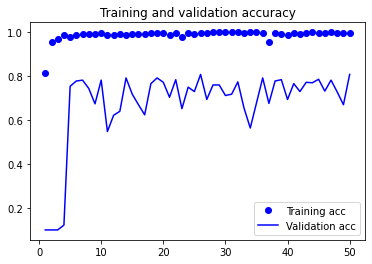

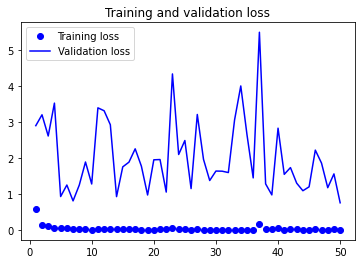

In [ ]:
#Gerando os gráficos
#Graphics

graph_plots(CResNET_History)

Mesmo que os resultados não sejam tão empolgantes quanto os anteriores, essa execução simula o que seria próximo da realidade e ainda assim as estatísticas são positivas.

------------------

Even with not as excitings results as before, this execution simulates what would be the closest to reality as possible and yet, the statics are positives.

Vamos então ver como o modelo irá estabilizar com uma taxa de aprendizado dinâmica, que começará alta e irá diminuindo, estabilizando o modelo em um mínimo e salvando sua melhor performance.

Para fazer isso, utilizaremos as seguintes callbacks do Keras:

<ul>
<li> A ReduceLROnPlateau, onde fixaremos uma paciência(patience) e, se a perda não diminuir em cinco épocas, ele reduzirá a taxa de aprendizado.
<li> E a ModelCheckpoint, que salvará a melhor versão do nosso modelo.
</ul>

Também pode ser usada a callback EarlyStopping, que irá parar o modelo quando ele "parar de aprender", mas nós preferimos maiximizar a performance do modelo e buscar um mínimo.

-----

Lets look how the model would stabilize with a dinamic learning rate, that starts high and slowly decreases, stabilizing the model in a minimun and saving his best performance.

To do this, we will use the following Keras callbacks:



*   ReduceLROnPlateau, when we fix a patience value and, if the loss do not low in five epochs, it will reduce the Learning Rate
*   And ModelCheckpoint, who will save the best model.

It is also possible to use the EarlyStopping callback, who will stop the training when the model "stops learning", but we prefer maximize the model performance and search for a minimum.





In [ ]:
from keras import callbacks

def callbacks_list(name, file_path='',monitor = 'val_loss'):
    callbacks_list = [
                    callbacks.ReduceLROnPlateau(
                        monitor=monitor,
                        factor=0.1,
                        patience=5,
                        ),
                    callbacks.ModelCheckpoint(
                        filepath=os.path.join(file_path,name+'.h5'),
                        monitor=monitor,
                        save_best_only=True,
                        mode="auto",
                        save_weights_only=False,
                        ),
                    ]
    return callbacks_list

In [ ]:
callbacks_list = callbacks_list('CroppedResNET')

In [ ]:
CResNet = build_CroppedResNET((20,100,1))

In [ ]:
CResNET_History = CResNet.fit(x= X_train,
                            y = one_hot_y_train,
                            epochs=50,
                            batch_size=32,
                            validation_data=(X_val, one_hot_y_val),
                            callbacks= callbacks_list)

Epoch 1/50
79/79 [==============================] - 24s 138ms/step - loss: 0.6019 - acc: 0.8188 - val_loss: 3.3082 - val_acc: 0.1000 - lr: 0.0010
Epoch 2/50
79/79 [==============================] - 7s 91ms/step - loss: 0.1501 - acc: 0.9496 - val_loss: 3.0681 - val_acc: 0.1000 - lr: 0.0010
Epoch 3/50
79/79 [==============================] - 5s 69ms/step - loss: 0.1164 - acc: 0.9640 - val_loss: 3.4611 - val_acc: 0.1000 - lr: 0.0010
Epoch 4/50
79/79 [==============================] - 6s 71ms/step - loss: 0.0529 - acc: 0.9856 - val_loss: 3.8509 - val_acc: 0.1100 - lr: 0.0010
Epoch 5/50
79/79 [==============================] - 9s 118ms/step - loss: 0.0363 - acc: 0.9912 - val_loss: 2.9226 - val_acc: 0.3040 - lr: 0.0010
Epoch 6/50
79/79 [==============================] - 7s 91ms/step - loss: 0.0297 - acc: 0.9924 - val_loss: 0.6140 - val_acc: 0.8120 - lr: 0.0010
Epoch 7/50
79/79 [==============================] - 5s 68ms/step - loss: 0.0322 - acc: 0.9892 - val_loss: 2.6951 - val_acc: 0.5460 - 

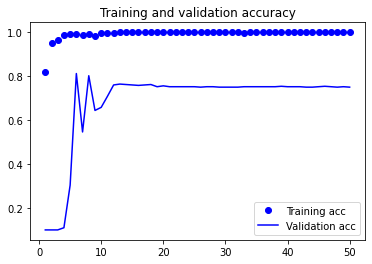

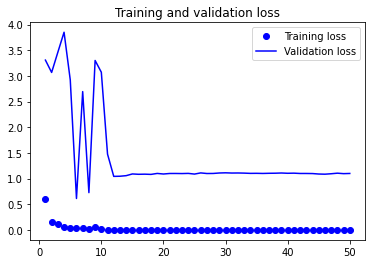

In [ ]:
graph_plots(CResNET_History)

Antes que avancemos para conclusões e próximos passos, vamos checar como o modelo performa quanto é apresentado a um sotaque desconhecido.

-----

Before we reach conclusions and next steps, lets check how the model performance is when we feed it an unknown accent.

## Validando a rede com George

-------

## Validating the network with George

In [ ]:
df_train = df.query("Speaker != 'george'")
df_val = df.query("Speaker == 'george'")
df_val = df_val.copy()
df_val.reset_index(drop=True, inplace=True)
df_train = df_train.copy()
df_train.reset_index(drop=True, inplace=True)
lbl = LabelEncoder()
y_train = lbl.fit_transform(df_train[['digit']])
y_val = lbl.fit_transform(df_val[['digit']])
one_hot_y_train = to_categorical(y_train)
one_hot_y_val = to_categorical(y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_train = []
for i in df_train['Pathing']:
  x = cropwav2mfcc(i)
  print(i)
  X_train.append(x)

free-spoken-digit-dataset/recordings/0_jackson_0.wav
free-spoken-digit-dataset/recordings/0_jackson_1.wav
free-spoken-digit-dataset/recordings/0_jackson_10.wav
free-spoken-digit-dataset/recordings/0_jackson_11.wav
free-spoken-digit-dataset/recordings/0_jackson_12.wav
free-spoken-digit-dataset/recordings/0_jackson_13.wav
free-spoken-digit-dataset/recordings/0_jackson_14.wav
free-spoken-digit-dataset/recordings/0_jackson_15.wav
free-spoken-digit-dataset/recordings/0_jackson_16.wav
free-spoken-digit-dataset/recordings/0_jackson_17.wav
free-spoken-digit-dataset/recordings/0_jackson_18.wav
free-spoken-digit-dataset/recordings/0_jackson_19.wav
free-spoken-digit-dataset/recordings/0_jackson_2.wav
free-spoken-digit-dataset/recordings/0_jackson_20.wav
free-spoken-digit-dataset/recordings/0_jackson_21.wav
free-spoken-digit-dataset/recordings/0_jackson_22.wav
free-spoken-digit-dataset/recordings/0_jackson_23.wav
free-spoken-digit-dataset/recordings/0_jackson_24.wav
free-spoken-digit-dataset/recor

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1983
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_lucas_32.wav
free-spoken-digit-dataset/recordings/1_lucas_33.wav
free-spoken-digit-dataset/recordings/1_lucas_34.wav
free-spoken-digit-dataset/recordings/1_lucas_35.wav
free-spoken-digit-dataset/recordings/1_lucas_36.wav
free-spoken-digit-dataset/recordings/1_lucas_37.wav
free-spoken-digit-dataset/recordings/1_lucas_38.wav
free-spoken-digit-dataset/recordings/1_lucas_39.wav
free-spoken-digit-dataset/recordings/1_lucas_4.wav
free-spoken-digit-dataset/recordings/1_lucas_40.wav
free-spoken-digit-dataset/recordings/1_lucas_41.wav
free-spoken-digit-dataset/recordings/1_lucas_42.wav
free-spoken-digit-dataset/recordings/1_lucas_43.wav
free-spoken-digit-dataset/recordings/1_lucas_44.wav
free-spoken-digit-dataset/recordings/1_lucas_45.wav
free-spoken-digit-dataset/recordings/1_lucas_46.wav
free-spoken-digit-dataset/recordings/1_lucas_47.wav
free-spoken-digit-dataset/recordings/1_lucas_48.wav
free-spoken-digit-dataset/recordings/1_lucas_49.wav
free-spoken-d

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2033
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1963
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2007
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_nicolas_19.wav
free-spoken-digit-dataset/recordings/1_nicolas_2.wav
free-spoken-digit-dataset/recordings/1_nicolas_20.wav
free-spoken-digit-dataset/recordings/1_nicolas_21.wav
free-spoken-digit-dataset/recordings/1_nicolas_22.wav
free-spoken-digit-dataset/recordings/1_nicolas_23.wav
free-spoken-digit-dataset/recordings/1_nicolas_24.wav
free-spoken-digit-dataset/recordings/1_nicolas_25.wav
free-spoken-digit-dataset/recordings/1_nicolas_26.wav
free-spoken-digit-dataset/recordings/1_nicolas_27.wav
free-spoken-digit-dataset/recordings/1_nicolas_28.wav
free-spoken-digit-dataset/recordings/1_nicolas_29.wav
free-spoken-digit-dataset/recordings/1_nicolas_3.wav
free-spoken-digit-dataset/recordings/1_nicolas_30.wav
free-spoken-digit-dataset/recordings/1_nicolas_31.wav
free-spoken-digit-dataset/recordings/1_nicolas_32.wav
free-spoken-digit-dataset/recordings/1_nicolas_33.wav
free-spoken-digit-dataset/recordings/1_nicolas_34.wav
free-spoken-digit-dataset/reco

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1976
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1987
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1886
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1842
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1753
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1870
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/1_nicolas_9.wav
free-spoken-digit-dataset/recordings/1_theo_0.wav
free-spoken-digit-dataset/recordings/1_theo_1.wav
free-spoken-digit-dataset/recordings/1_theo_10.wav
free-spoken-digit-dataset/recordings/1_theo_11.wav
free-spoken-digit-dataset/recordings/1_theo_12.wav
free-spoken-digit-dataset/recordings/1_theo_13.wav
free-spoken-digit-dataset/recordings/1_theo_14.wav
free-spoken-digit-dataset/recordings/1_theo_15.wav
free-spoken-digit-dataset/recordings/1_theo_16.wav
free-spoken-digit-dataset/recordings/1_theo_17.wav
free-spoken-digit-dataset/recordings/1_theo_18.wav
free-spoken-digit-dataset/recordings/1_theo_19.wav
free-spoken-digit-dataset/recordings/1_theo_2.wav
free-spoken-digit-dataset/recordings/1_theo_20.wav
free-spoken-digit-dataset/recordings/1_theo_21.wav
free-spoken-digit-dataset/recordings/1_theo_22.wav
free-spoken-digit-dataset/recordings/1_theo_23.wav
free-spoken-digit-dataset/recordings/1_theo_24.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1556
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1997
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_theo_25.wav
free-spoken-digit-dataset/recordings/1_theo_26.wav
free-spoken-digit-dataset/recordings/1_theo_27.wav
free-spoken-digit-dataset/recordings/1_theo_28.wav
free-spoken-digit-dataset/recordings/1_theo_29.wav
free-spoken-digit-dataset/recordings/1_theo_3.wav
free-spoken-digit-dataset/recordings/1_theo_30.wav
free-spoken-digit-dataset/recordings/1_theo_31.wav
free-spoken-digit-dataset/recordings/1_theo_32.wav
free-spoken-digit-dataset/recordings/1_theo_33.wav
free-spoken-digit-dataset/recordings/1_theo_34.wav
free-spoken-digit-dataset/recordings/1_theo_35.wav
free-spoken-digit-dataset/recordings/1_theo_36.wav
free-spoken-digit-dataset/recordings/1_theo_37.wav
free-spoken-digit-dataset/recordings/1_theo_38.wav
free-spoken-digit-dataset/recordings/1_theo_39.wav
free-spoken-digit-dataset/recordings/1_theo_4.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1720
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1692
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1565
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1737
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1890
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/1_theo_40.wav
free-spoken-digit-dataset/recordings/1_theo_41.wav
free-spoken-digit-dataset/recordings/1_theo_42.wav
free-spoken-digit-dataset/recordings/1_theo_43.wav
free-spoken-digit-dataset/recordings/1_theo_44.wav
free-spoken-digit-dataset/recordings/1_theo_45.wav
free-spoken-digit-dataset/recordings/1_theo_46.wav
free-spoken-digit-dataset/recordings/1_theo_47.wav
free-spoken-digit-dataset/recordings/1_theo_48.wav
free-spoken-digit-dataset/recordings/1_theo_49.wav
free-spoken-digit-dataset/recordings/1_theo_5.wav
free-spoken-digit-dataset/recordings/1_theo_6.wav
free-spoken-digit-dataset/recordings/1_theo_7.wav
free-spoken-digit-dataset/recordings/1_theo_8.wav
free-spoken-digit-dataset/recordings/1_theo_9.wav
free-spoken-digit-dataset/recordings/1_yweweler_0.wav
free-spoken-digit-dataset/recordings/1_yweweler_1.wav
free-spoken-digit-dataset/recordings/1_yweweler_10.wav
free-spoken-digit-dataset/recordings/1_yweweler_11.wav
free-spoken-digit-data

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2016
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_yweweler_47.wav
free-spoken-digit-dataset/recordings/1_yweweler_48.wav
free-spoken-digit-dataset/recordings/1_yweweler_49.wav
free-spoken-digit-dataset/recordings/1_yweweler_5.wav
free-spoken-digit-dataset/recordings/1_yweweler_6.wav
free-spoken-digit-dataset/recordings/1_yweweler_7.wav
free-spoken-digit-dataset/recordings/1_yweweler_8.wav
free-spoken-digit-dataset/recordings/1_yweweler_9.wav
free-spoken-digit-dataset/recordings/2_jackson_0.wav
free-spoken-digit-dataset/recordings/2_jackson_1.wav
free-spoken-digit-dataset/recordings/2_jackson_10.wav
free-spoken-digit-dataset/recordings/2_jackson_11.wav
free-spoken-digit-dataset/recordings/2_jackson_12.wav
free-spoken-digit-dataset/recordings/2_jackson_13.wav
free-spoken-digit-dataset/recordings/2_jackson_14.wav
free-spoken-digit-dataset/recordings/2_jackson_15.wav
free-spoken-digit-dataset/recordings/2_jackson_16.wav
free-spoken-digit-dataset/recordings/2_jackson_17.wav
free-spoken-digit-dataset/r

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1493
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1525
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1742
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1866
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1914
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1568
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/2_nicolas_22.wav
free-spoken-digit-dataset/recordings/2_nicolas_23.wav
free-spoken-digit-dataset/recordings/2_nicolas_24.wav
free-spoken-digit-dataset/recordings/2_nicolas_25.wav
free-spoken-digit-dataset/recordings/2_nicolas_26.wav
free-spoken-digit-dataset/recordings/2_nicolas_27.wav
free-spoken-digit-dataset/recordings/2_nicolas_28.wav
free-spoken-digit-dataset/recordings/2_nicolas_29.wav
free-spoken-digit-dataset/recordings/2_nicolas_3.wav
free-spoken-digit-dataset/recordings/2_nicolas_30.wav
free-spoken-digit-dataset/recordings/2_nicolas_31.wav
free-spoken-digit-dataset/recordings/2_nicolas_32.wav
free-spoken-digit-dataset/recordings/2_nicolas_33.wav
free-spoken-digit-dataset/recordings/2_nicolas_34.wav
free-spoken-digit-dataset/recordings/2_nicolas_35.wav
free-spoken-digit-dataset/recordings/2_nicolas_36.wav
free-spoken-digit-dataset/recordings/2_nicolas_37.wav
free-spoken-digit-dataset/recordings/2_nicolas_38.wav
free-spoken-digit-dataset/rec

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1475
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1852
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1953
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1819
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1664
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1962
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/2_theo_13.wav
free-spoken-digit-dataset/recordings/2_theo_14.wav
free-spoken-digit-dataset/recordings/2_theo_15.wav
free-spoken-digit-dataset/recordings/2_theo_16.wav
free-spoken-digit-dataset/recordings/2_theo_17.wav
free-spoken-digit-dataset/recordings/2_theo_18.wav
free-spoken-digit-dataset/recordings/2_theo_19.wav
free-spoken-digit-dataset/recordings/2_theo_2.wav
free-spoken-digit-dataset/recordings/2_theo_20.wav
free-spoken-digit-dataset/recordings/2_theo_21.wav
free-spoken-digit-dataset/recordings/2_theo_22.wav
free-spoken-digit-dataset/recordings/2_theo_23.wav
free-spoken-digit-dataset/recordings/2_theo_24.wav
free-spoken-digit-dataset/recordings/2_theo_25.wav
free-spoken-digit-dataset/recordings/2_theo_26.wav
free-spoken-digit-dataset/recordings/2_theo_27.wav
free-spoken-digit-dataset/recordings/2_theo_28.wav
free-spoken-digit-dataset/recordings/2_theo_29.wav
free-spoken-digit-dataset/recordings/2_theo_3.wav
free-spoken-digit-dataset/recordi

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1601
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1288
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1854
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1807
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/2_theo_45.wav
free-spoken-digit-dataset/recordings/2_theo_46.wav
free-spoken-digit-dataset/recordings/2_theo_47.wav
free-spoken-digit-dataset/recordings/2_theo_48.wav
free-spoken-digit-dataset/recordings/2_theo_49.wav
free-spoken-digit-dataset/recordings/2_theo_5.wav
free-spoken-digit-dataset/recordings/2_theo_6.wav
free-spoken-digit-dataset/recordings/2_theo_7.wav
free-spoken-digit-dataset/recordings/2_theo_8.wav
free-spoken-digit-dataset/recordings/2_theo_9.wav
free-spoken-digit-dataset/recordings/2_yweweler_0.wav
free-spoken-digit-dataset/recordings/2_yweweler_1.wav
free-spoken-digit-dataset/recordings/2_yweweler_10.wav
free-spoken-digit-dataset/recordings/2_yweweler_11.wav
free-spoken-digit-dataset/recordings/2_yweweler_12.wav
free-spoken-digit-dataset/recordings/2_yweweler_13.wav
free-spoken-digit-dataset/recordings/2_yweweler_14.wav
free-spoken-digit-dataset/recordings/2_yweweler_15.wav
free-spoken-digit-dataset/recordings/2_yweweler_16.wav
fr

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1704
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1896
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2042
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2037
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1943
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2027
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/2_yweweler_18.wav
free-spoken-digit-dataset/recordings/2_yweweler_19.wav
free-spoken-digit-dataset/recordings/2_yweweler_2.wav
free-spoken-digit-dataset/recordings/2_yweweler_20.wav
free-spoken-digit-dataset/recordings/2_yweweler_21.wav
free-spoken-digit-dataset/recordings/2_yweweler_22.wav
free-spoken-digit-dataset/recordings/2_yweweler_23.wav
free-spoken-digit-dataset/recordings/2_yweweler_24.wav
free-spoken-digit-dataset/recordings/2_yweweler_25.wav
free-spoken-digit-dataset/recordings/2_yweweler_26.wav
free-spoken-digit-dataset/recordings/2_yweweler_27.wav
free-spoken-digit-dataset/recordings/2_yweweler_28.wav
free-spoken-digit-dataset/recordings/2_yweweler_29.wav
free-spoken-digit-dataset/recordings/2_yweweler_3.wav
free-spoken-digit-dataset/recordings/2_yweweler_30.wav
free-spoken-digit-dataset/recordings/2_yweweler_31.wav
free-spoken-digit-dataset/recordings/2_yweweler_32.wav
free-spoken-digit-dataset/recordings/2_yweweler_33.wav
free-spoken-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1906
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1900
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/2_yweweler_36.wav
free-spoken-digit-dataset/recordings/2_yweweler_37.wav
free-spoken-digit-dataset/recordings/2_yweweler_38.wav
free-spoken-digit-dataset/recordings/2_yweweler_39.wav
free-spoken-digit-dataset/recordings/2_yweweler_4.wav
free-spoken-digit-dataset/recordings/2_yweweler_40.wav
free-spoken-digit-dataset/recordings/2_yweweler_41.wav
free-spoken-digit-dataset/recordings/2_yweweler_42.wav
free-spoken-digit-dataset/recordings/2_yweweler_43.wav
free-spoken-digit-dataset/recordings/2_yweweler_44.wav
free-spoken-digit-dataset/recordings/2_yweweler_45.wav
free-spoken-digit-dataset/recordings/2_yweweler_46.wav
free-spoken-digit-dataset/recordings/2_yweweler_47.wav
free-spoken-digit-dataset/recordings/2_yweweler_48.wav
free-spoken-digit-dataset/recordings/2_yweweler_49.wav
free-spoken-digit-dataset/recordings/2_yweweler_5.wav
free-spoken-digit-dataset/recordings/2_yweweler_6.wav
free-spoken-digit-dataset/recordings/2_yweweler_7.wav
free-spoken-di

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2034
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1973
  n_fft, y.shape[-1]



free-spoken-digit-dataset/recordings/3_jackson_0.wav
free-spoken-digit-dataset/recordings/3_jackson_1.wav
free-spoken-digit-dataset/recordings/3_jackson_10.wav
free-spoken-digit-dataset/recordings/3_jackson_11.wav
free-spoken-digit-dataset/recordings/3_jackson_12.wav
free-spoken-digit-dataset/recordings/3_jackson_13.wav
free-spoken-digit-dataset/recordings/3_jackson_14.wav
free-spoken-digit-dataset/recordings/3_jackson_15.wav
free-spoken-digit-dataset/recordings/3_jackson_16.wav
free-spoken-digit-dataset/recordings/3_jackson_17.wav
free-spoken-digit-dataset/recordings/3_jackson_18.wav
free-spoken-digit-dataset/recordings/3_jackson_19.wav
free-spoken-digit-dataset/recordings/3_jackson_2.wav
free-spoken-digit-dataset/recordings/3_jackson_20.wav
free-spoken-digit-dataset/recordings/3_jackson_21.wav
free-spoken-digit-dataset/recordings/3_jackson_22.wav
free-spoken-digit-dataset/recordings/3_jackson_23.wav
free-spoken-digit-dataset/recordings/3_jackson_24.wav
free-spoken-digit-dataset/reco

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1640
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1547
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1516
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1609
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1455
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1650
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/3_nicolas_23.wav
free-spoken-digit-dataset/recordings/3_nicolas_24.wav
free-spoken-digit-dataset/recordings/3_nicolas_25.wav
free-spoken-digit-dataset/recordings/3_nicolas_26.wav
free-spoken-digit-dataset/recordings/3_nicolas_27.wav
free-spoken-digit-dataset/recordings/3_nicolas_28.wav
free-spoken-digit-dataset/recordings/3_nicolas_29.wav
free-spoken-digit-dataset/recordings/3_nicolas_3.wav
free-spoken-digit-dataset/recordings/3_nicolas_30.wav
free-spoken-digit-dataset/recordings/3_nicolas_31.wav
free-spoken-digit-dataset/recordings/3_nicolas_32.wav
free-spoken-digit-dataset/recordings/3_nicolas_33.wav
free-spoken-digit-dataset/recordings/3_nicolas_34.wav
free-spoken-digit-dataset/recordings/3_nicolas_35.wav
free-spoken-digit-dataset/recordings/3_nicolas_36.wav
free-spoken-digit-dataset/recordings/3_nicolas_37.wav
free-spoken-digit-dataset/recordings/3_nicolas_38.wav
free-spoken-digit-dataset/recordings/3_nicolas_39.wav
free-spoken-digit-dataset/rec

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1884
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1805
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1713
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2023
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_nicolas_41.wav
free-spoken-digit-dataset/recordings/3_nicolas_42.wav
free-spoken-digit-dataset/recordings/3_nicolas_43.wav
free-spoken-digit-dataset/recordings/3_nicolas_44.wav
free-spoken-digit-dataset/recordings/3_nicolas_45.wav
free-spoken-digit-dataset/recordings/3_nicolas_46.wav
free-spoken-digit-dataset/recordings/3_nicolas_47.wav
free-spoken-digit-dataset/recordings/3_nicolas_48.wav
free-spoken-digit-dataset/recordings/3_nicolas_49.wav
free-spoken-digit-dataset/recordings/3_nicolas_5.wav
free-spoken-digit-dataset/recordings/3_nicolas_6.wav
free-spoken-digit-dataset/recordings/3_nicolas_7.wav
free-spoken-digit-dataset/recordings/3_nicolas_8.wav
free-spoken-digit-dataset/recordings/3_nicolas_9.wav
free-spoken-digit-dataset/recordings/3_theo_0.wav
free-spoken-digit-dataset/recordings/3_theo_1.wav
free-spoken-digit-dataset/recordings/3_theo_10.wav
free-spoken-digit-dataset/recordings/3_theo_11.wav
free-spoken-digit-dataset/recordings/3_theo_12.

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1915
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1931
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1793
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1824
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1579
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1817
  n_fft, y.shape[-1]



free-spoken-digit-dataset/recordings/3_theo_14.wav
free-spoken-digit-dataset/recordings/3_theo_15.wav
free-spoken-digit-dataset/recordings/3_theo_16.wav
free-spoken-digit-dataset/recordings/3_theo_17.wav
free-spoken-digit-dataset/recordings/3_theo_18.wav
free-spoken-digit-dataset/recordings/3_theo_19.wav
free-spoken-digit-dataset/recordings/3_theo_2.wav
free-spoken-digit-dataset/recordings/3_theo_20.wav
free-spoken-digit-dataset/recordings/3_theo_21.wav
free-spoken-digit-dataset/recordings/3_theo_22.wav
free-spoken-digit-dataset/recordings/3_theo_23.wav
free-spoken-digit-dataset/recordings/3_theo_24.wav
free-spoken-digit-dataset/recordings/3_theo_25.wav
free-spoken-digit-dataset/recordings/3_theo_26.wav
free-spoken-digit-dataset/recordings/3_theo_27.wav
free-spoken-digit-dataset/recordings/3_theo_28.wav
free-spoken-digit-dataset/recordings/3_theo_29.wav
free-spoken-digit-dataset/recordings/3_theo_3.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1876
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1958
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1795
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2036
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1846
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_theo_30.wav
free-spoken-digit-dataset/recordings/3_theo_31.wav
free-spoken-digit-dataset/recordings/3_theo_32.wav
free-spoken-digit-dataset/recordings/3_theo_33.wav
free-spoken-digit-dataset/recordings/3_theo_34.wav
free-spoken-digit-dataset/recordings/3_theo_35.wav
free-spoken-digit-dataset/recordings/3_theo_36.wav
free-spoken-digit-dataset/recordings/3_theo_37.wav
free-spoken-digit-dataset/recordings/3_theo_38.wav
free-spoken-digit-dataset/recordings/3_theo_39.wav
free-spoken-digit-dataset/recordings/3_theo_4.wav
free-spoken-digit-dataset/recordings/3_theo_40.wav
free-spoken-digit-dataset/recordings/3_theo_41.wav
free-spoken-digit-dataset/recordings/3_theo_42.wav
free-spoken-digit-dataset/recordings/3_theo_43.wav
free-spoken-digit-dataset/recordings/3_theo_44.wav
free-spoken-digit-dataset/recordings/3_theo_45.wav
free-spoken-digit-dataset/recordings/3_theo_46.wav
free-spoken-digit-dataset/recordings/3_theo_47.wav
free-spoken-digit-dataset/record

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1803
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1945
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2001
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1892
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_yweweler_18.wav
free-spoken-digit-dataset/recordings/3_yweweler_19.wav
free-spoken-digit-dataset/recordings/3_yweweler_2.wav
free-spoken-digit-dataset/recordings/3_yweweler_20.wav
free-spoken-digit-dataset/recordings/3_yweweler_21.wav
free-spoken-digit-dataset/recordings/3_yweweler_22.wav
free-spoken-digit-dataset/recordings/3_yweweler_23.wav
free-spoken-digit-dataset/recordings/3_yweweler_24.wav
free-spoken-digit-dataset/recordings/3_yweweler_25.wav
free-spoken-digit-dataset/recordings/3_yweweler_26.wav
free-spoken-digit-dataset/recordings/3_yweweler_27.wav
free-spoken-digit-dataset/recordings/3_yweweler_28.wav
free-spoken-digit-dataset/recordings/3_yweweler_29.wav
free-spoken-digit-dataset/recordings/3_yweweler_3.wav
free-spoken-digit-dataset/recordings/3_yweweler_30.wav
free-spoken-digit-dataset/recordings/3_yweweler_31.wav
free-spoken-digit-dataset/recordings/3_yweweler_32.wav
free-spoken-digit-dataset/recordings/3_yweweler_33.wav
free-spoken-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2005
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1697
  n_fft, y.shape[-1]



free-spoken-digit-dataset/recordings/3_yweweler_35.wav
free-spoken-digit-dataset/recordings/3_yweweler_36.wav
free-spoken-digit-dataset/recordings/3_yweweler_37.wav
free-spoken-digit-dataset/recordings/3_yweweler_38.wav
free-spoken-digit-dataset/recordings/3_yweweler_39.wav
free-spoken-digit-dataset/recordings/3_yweweler_4.wav
free-spoken-digit-dataset/recordings/3_yweweler_40.wav
free-spoken-digit-dataset/recordings/3_yweweler_41.wav
free-spoken-digit-dataset/recordings/3_yweweler_42.wav
free-spoken-digit-dataset/recordings/3_yweweler_43.wav
free-spoken-digit-dataset/recordings/3_yweweler_44.wav
free-spoken-digit-dataset/recordings/3_yweweler_45.wav
free-spoken-digit-dataset/recordings/3_yweweler_46.wav
free-spoken-digit-dataset/recordings/3_yweweler_47.wav
free-spoken-digit-dataset/recordings/3_yweweler_48.wav
free-spoken-digit-dataset/recordings/3_yweweler_49.wav
free-spoken-digit-dataset/recordings/3_yweweler_5.wav
free-spoken-digit-dataset/recordings/3_yweweler_6.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1903
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1919
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_yweweler_7.wav
free-spoken-digit-dataset/recordings/3_yweweler_8.wav
free-spoken-digit-dataset/recordings/3_yweweler_9.wav
free-spoken-digit-dataset/recordings/4_jackson_0.wav
free-spoken-digit-dataset/recordings/4_jackson_1.wav
free-spoken-digit-dataset/recordings/4_jackson_10.wav
free-spoken-digit-dataset/recordings/4_jackson_11.wav
free-spoken-digit-dataset/recordings/4_jackson_12.wav
free-spoken-digit-dataset/recordings/4_jackson_13.wav
free-spoken-digit-dataset/recordings/4_jackson_14.wav
free-spoken-digit-dataset/recordings/4_jackson_15.wav
free-spoken-digit-dataset/recordings/4_jackson_16.wav
free-spoken-digit-dataset/recordings/4_jackson_17.wav
free-spoken-digit-dataset/recordings/4_jackson_18.wav
free-spoken-digit-dataset/recordings/4_jackson_19.wav
free-spoken-digit-dataset/recordings/4_jackson_2.wav
free-spoken-digit-dataset/recordings/4_jackson_20.wav
free-spoken-digit-dataset/recordings/4_jackson_21.wav
free-spoken-digit-dataset/recor

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1832
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_nicolas_43.wav
free-spoken-digit-dataset/recordings/4_nicolas_44.wav
free-spoken-digit-dataset/recordings/4_nicolas_45.wav
free-spoken-digit-dataset/recordings/4_nicolas_46.wav
free-spoken-digit-dataset/recordings/4_nicolas_47.wav
free-spoken-digit-dataset/recordings/4_nicolas_48.wav
free-spoken-digit-dataset/recordings/4_nicolas_49.wav
free-spoken-digit-dataset/recordings/4_nicolas_5.wav
free-spoken-digit-dataset/recordings/4_nicolas_6.wav
free-spoken-digit-dataset/recordings/4_nicolas_7.wav
free-spoken-digit-dataset/recordings/4_nicolas_8.wav
free-spoken-digit-dataset/recordings/4_nicolas_9.wav
free-spoken-digit-dataset/recordings/4_theo_0.wav
free-spoken-digit-dataset/recordings/4_theo_1.wav
free-spoken-digit-dataset/recordings/4_theo_10.wav
free-spoken-digit-dataset/recordings/4_theo_11.wav
free-spoken-digit-dataset/recordings/4_theo_12.wav
free-spoken-digit-dataset/recordings/4_theo_13.wav
free-spoken-digit-dataset/recordings/4_theo_14.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2039
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1873
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1632
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1806
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2022
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_theo_15.wav
free-spoken-digit-dataset/recordings/4_theo_16.wav
free-spoken-digit-dataset/recordings/4_theo_17.wav
free-spoken-digit-dataset/recordings/4_theo_18.wav
free-spoken-digit-dataset/recordings/4_theo_19.wav
free-spoken-digit-dataset/recordings/4_theo_2.wav
free-spoken-digit-dataset/recordings/4_theo_20.wav
free-spoken-digit-dataset/recordings/4_theo_21.wav
free-spoken-digit-dataset/recordings/4_theo_22.wav
free-spoken-digit-dataset/recordings/4_theo_23.wav
free-spoken-digit-dataset/recordings/4_theo_24.wav
free-spoken-digit-dataset/recordings/4_theo_25.wav
free-spoken-digit-dataset/recordings/4_theo_26.wav
free-spoken-digit-dataset/recordings/4_theo_27.wav
free-spoken-digit-dataset/recordings/4_theo_28.wav
free-spoken-digit-dataset/recordings/4_theo_29.wav
free-spoken-digit-dataset/recordings/4_theo_3.wav
free-spoken-digit-dataset/recordings/4_theo_30.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2014
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2045
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_theo_31.wav
free-spoken-digit-dataset/recordings/4_theo_32.wav
free-spoken-digit-dataset/recordings/4_theo_33.wav
free-spoken-digit-dataset/recordings/4_theo_34.wav
free-spoken-digit-dataset/recordings/4_theo_35.wav
free-spoken-digit-dataset/recordings/4_theo_36.wav
free-spoken-digit-dataset/recordings/4_theo_37.wav
free-spoken-digit-dataset/recordings/4_theo_38.wav
free-spoken-digit-dataset/recordings/4_theo_39.wav
free-spoken-digit-dataset/recordings/4_theo_4.wav
free-spoken-digit-dataset/recordings/4_theo_40.wav
free-spoken-digit-dataset/recordings/4_theo_41.wav
free-spoken-digit-dataset/recordings/4_theo_42.wav
free-spoken-digit-dataset/recordings/4_theo_43.wav
free-spoken-digit-dataset/recordings/4_theo_44.wav
free-spoken-digit-dataset/recordings/4_theo_45.wav
free-spoken-digit-dataset/recordings/4_theo_46.wav
free-spoken-digit-dataset/recordings/4_theo_47.wav
free-spoken-digit-dataset/recordings/4_theo_48.wav
free-spoken-digit-dataset/record

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1790
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1705
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_yweweler_20.wav
free-spoken-digit-dataset/recordings/4_yweweler_21.wav
free-spoken-digit-dataset/recordings/4_yweweler_22.wav
free-spoken-digit-dataset/recordings/4_yweweler_23.wav
free-spoken-digit-dataset/recordings/4_yweweler_24.wav
free-spoken-digit-dataset/recordings/4_yweweler_25.wav
free-spoken-digit-dataset/recordings/4_yweweler_26.wav
free-spoken-digit-dataset/recordings/4_yweweler_27.wav
free-spoken-digit-dataset/recordings/4_yweweler_28.wav
free-spoken-digit-dataset/recordings/4_yweweler_29.wav
free-spoken-digit-dataset/recordings/4_yweweler_3.wav
free-spoken-digit-dataset/recordings/4_yweweler_30.wav
free-spoken-digit-dataset/recordings/4_yweweler_31.wav
free-spoken-digit-dataset/recordings/4_yweweler_32.wav
free-spoken-digit-dataset/recordings/4_yweweler_33.wav
free-spoken-digit-dataset/recordings/4_yweweler_34.wav
free-spoken-digit-dataset/recordings/4_yweweler_35.wav
free-spoken-digit-dataset/recordings/4_yweweler_36.wav
free-spoken

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1359
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/4_yweweler_9.wav
free-spoken-digit-dataset/recordings/5_jackson_0.wav
free-spoken-digit-dataset/recordings/5_jackson_1.wav
free-spoken-digit-dataset/recordings/5_jackson_10.wav
free-spoken-digit-dataset/recordings/5_jackson_11.wav
free-spoken-digit-dataset/recordings/5_jackson_12.wav
free-spoken-digit-dataset/recordings/5_jackson_13.wav
free-spoken-digit-dataset/recordings/5_jackson_14.wav
free-spoken-digit-dataset/recordings/5_jackson_15.wav
free-spoken-digit-dataset/recordings/5_jackson_16.wav
free-spoken-digit-dataset/recordings/5_jackson_17.wav
free-spoken-digit-dataset/recordings/5_jackson_18.wav
free-spoken-digit-dataset/recordings/5_jackson_19.wav
free-spoken-digit-dataset/recordings/5_jackson_2.wav
free-spoken-digit-dataset/recordings/5_jackson_20.wav
free-spoken-digit-dataset/recordings/5_jackson_21.wav
free-spoken-digit-dataset/recordings/5_jackson_22.wav
free-spoken-digit-dataset/recordings/5_jackson_23.wav
free-spoken-digit-dataset/recor

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1673
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1970
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/5_theo_34.wav
free-spoken-digit-dataset/recordings/5_theo_35.wav
free-spoken-digit-dataset/recordings/5_theo_36.wav
free-spoken-digit-dataset/recordings/5_theo_37.wav
free-spoken-digit-dataset/recordings/5_theo_38.wav
free-spoken-digit-dataset/recordings/5_theo_39.wav
free-spoken-digit-dataset/recordings/5_theo_4.wav
free-spoken-digit-dataset/recordings/5_theo_40.wav
free-spoken-digit-dataset/recordings/5_theo_41.wav
free-spoken-digit-dataset/recordings/5_theo_42.wav
free-spoken-digit-dataset/recordings/5_theo_43.wav
free-spoken-digit-dataset/recordings/5_theo_44.wav
free-spoken-digit-dataset/recordings/5_theo_45.wav
free-spoken-digit-dataset/recordings/5_theo_46.wav
free-spoken-digit-dataset/recordings/5_theo_47.wav
free-spoken-digit-dataset/recordings/5_theo_48.wav
free-spoken-digit-dataset/recordings/5_theo_49.wav
free-spoken-digit-dataset/recordings/5_theo_5.wav
free-spoken-digit-dataset/recordings/5_theo_6.wav
free-spoken-digit-dataset/recordin

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1722
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1850
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1843
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1778
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1433
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1296
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/6_nicolas_17.wav
free-spoken-digit-dataset/recordings/6_nicolas_18.wav
free-spoken-digit-dataset/recordings/6_nicolas_19.wav
free-spoken-digit-dataset/recordings/6_nicolas_2.wav
free-spoken-digit-dataset/recordings/6_nicolas_20.wav
free-spoken-digit-dataset/recordings/6_nicolas_21.wav
free-spoken-digit-dataset/recordings/6_nicolas_22.wav
free-spoken-digit-dataset/recordings/6_nicolas_23.wav
free-spoken-digit-dataset/recordings/6_nicolas_24.wav
free-spoken-digit-dataset/recordings/6_nicolas_25.wav
free-spoken-digit-dataset/recordings/6_nicolas_26.wav
free-spoken-digit-dataset/recordings/6_nicolas_27.wav
free-spoken-digit-dataset/recordings/6_nicolas_28.wav
free-spoken-digit-dataset/recordings/6_nicolas_29.wav
free-spoken-digit-dataset/recordings/6_nicolas_3.wav
free-spoken-digit-dataset/recordings/6_nicolas_30.wav
free-spoken-digit-dataset/recordings/6_nicolas_31.wav
free-spoken-digit-dataset/recordings/6_nicolas_32.wav
free-spoken-digit-dataset/reco

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2012
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1911
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1569
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1434
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1295
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1403
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/6_nicolas_34.wav
free-spoken-digit-dataset/recordings/6_nicolas_35.wav
free-spoken-digit-dataset/recordings/6_nicolas_36.wav
free-spoken-digit-dataset/recordings/6_nicolas_37.wav
free-spoken-digit-dataset/recordings/6_nicolas_38.wav
free-spoken-digit-dataset/recordings/6_nicolas_39.wav
free-spoken-digit-dataset/recordings/6_nicolas_4.wav
free-spoken-digit-dataset/recordings/6_nicolas_40.wav
free-spoken-digit-dataset/recordings/6_nicolas_41.wav
free-spoken-digit-dataset/recordings/6_nicolas_42.wav
free-spoken-digit-dataset/recordings/6_nicolas_43.wav
free-spoken-digit-dataset/recordings/6_nicolas_44.wav
free-spoken-digit-dataset/recordings/6_nicolas_45.wav
free-spoken-digit-dataset/recordings/6_nicolas_46.wav
free-spoken-digit-dataset/recordings/6_nicolas_47.wav
free-spoken-digit-dataset/recordings/6_nicolas_48.wav
free-spoken-digit-dataset/recordings/6_nicolas_49.wav
free-spoken-digit-dataset/recordings/6_nicolas_5.wav

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1593
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1913
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1149
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1259
  n_fft, y.shape[-1]



free-spoken-digit-dataset/recordings/6_nicolas_6.wav
free-spoken-digit-dataset/recordings/6_nicolas_7.wav
free-spoken-digit-dataset/recordings/6_nicolas_8.wav
free-spoken-digit-dataset/recordings/6_nicolas_9.wav
free-spoken-digit-dataset/recordings/6_theo_0.wav
free-spoken-digit-dataset/recordings/6_theo_1.wav
free-spoken-digit-dataset/recordings/6_theo_10.wav
free-spoken-digit-dataset/recordings/6_theo_11.wav
free-spoken-digit-dataset/recordings/6_theo_12.wav
free-spoken-digit-dataset/recordings/6_theo_13.wav
free-spoken-digit-dataset/recordings/6_theo_14.wav
free-spoken-digit-dataset/recordings/6_theo_15.wav
free-spoken-digit-dataset/recordings/6_theo_16.wav
free-spoken-digit-dataset/recordings/6_theo_17.wav
free-spoken-digit-dataset/recordings/6_theo_18.wav
free-spoken-digit-dataset/recordings/6_theo_19.wav
free-spoken-digit-dataset/recordings/6_theo_2.wav
free-spoken-digit-dataset/recordings/6_theo_20.wav
free-spoken-digit-dataset/recordings/6_theo_21.wav
free-spoken-digit-dataset

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1251
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1302
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1988
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1294
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1446
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1830
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/6_yweweler_25.wav
free-spoken-digit-dataset/recordings/6_yweweler_26.wav
free-spoken-digit-dataset/recordings/6_yweweler_27.wav
free-spoken-digit-dataset/recordings/6_yweweler_28.wav
free-spoken-digit-dataset/recordings/6_yweweler_29.wav
free-spoken-digit-dataset/recordings/6_yweweler_3.wav
free-spoken-digit-dataset/recordings/6_yweweler_30.wav
free-spoken-digit-dataset/recordings/6_yweweler_31.wav
free-spoken-digit-dataset/recordings/6_yweweler_32.wav
free-spoken-digit-dataset/recordings/6_yweweler_33.wav
free-spoken-digit-dataset/recordings/6_yweweler_34.wav
free-spoken-digit-dataset/recordings/6_yweweler_35.wav
free-spoken-digit-dataset/recordings/6_yweweler_36.wav
free-spoken-digit-dataset/recordings/6_yweweler_37.wav
free-spoken-digit-dataset/recordings/6_yweweler_38.wav
free-spoken-digit-dataset/recordings/6_yweweler_39.wav
free-spoken-digit-dataset/recordings/6_yweweler_4.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1682
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1148
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1838
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1502
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1763
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1450
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/6_yweweler_40.wav
free-spoken-digit-dataset/recordings/6_yweweler_41.wav
free-spoken-digit-dataset/recordings/6_yweweler_42.wav
free-spoken-digit-dataset/recordings/6_yweweler_43.wav
free-spoken-digit-dataset/recordings/6_yweweler_44.wav
free-spoken-digit-dataset/recordings/6_yweweler_45.wav
free-spoken-digit-dataset/recordings/6_yweweler_46.wav
free-spoken-digit-dataset/recordings/6_yweweler_47.wav
free-spoken-digit-dataset/recordings/6_yweweler_48.wav
free-spoken-digit-dataset/recordings/6_yweweler_49.wav
free-spoken-digit-dataset/recordings/6_yweweler_5.wav
free-spoken-digit-dataset/recordings/6_yweweler_6.wav
free-spoken-digit-dataset/recordings/6_yweweler_7.wav
free-spoken-digit-dataset/recordings/6_yweweler_8.wav
free-spoken-digit-dataset/recordings/6_yweweler_9.wav
free-spoken-digit-dataset/recordings/7_jackson_0.wav
free-spoken-digit-dataset/recordings/7_jackson_1.wav
free-spoken-digit-dataset/recordings/7_jackson_10.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1538
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1833
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1443
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2043
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1567
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1781
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

free-spoken-digit-dataset/recordings/7_jackson_11.wav
free-spoken-digit-dataset/recordings/7_jackson_12.wav
free-spoken-digit-dataset/recordings/7_jackson_13.wav
free-spoken-digit-dataset/recordings/7_jackson_14.wav
free-spoken-digit-dataset/recordings/7_jackson_15.wav
free-spoken-digit-dataset/recordings/7_jackson_16.wav
free-spoken-digit-dataset/recordings/7_jackson_17.wav
free-spoken-digit-dataset/recordings/7_jackson_18.wav
free-spoken-digit-dataset/recordings/7_jackson_19.wav
free-spoken-digit-dataset/recordings/7_jackson_2.wav
free-spoken-digit-dataset/recordings/7_jackson_20.wav
free-spoken-digit-dataset/recordings/7_jackson_21.wav
free-spoken-digit-dataset/recordings/7_jackson_22.wav
free-spoken-digit-dataset/recordings/7_jackson_23.wav
free-spoken-digit-dataset/recordings/7_jackson_24.wav
free-spoken-digit-dataset/recordings/7_jackson_25.wav
free-spoken-digit-dataset/recordings/7_jackson_26.wav
free-spoken-digit-dataset/recordings/7_jackson_27.wav
free-spoken-digit-dataset/rec

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1978
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/7_nicolas_29.wav
free-spoken-digit-dataset/recordings/7_nicolas_3.wav
free-spoken-digit-dataset/recordings/7_nicolas_30.wav
free-spoken-digit-dataset/recordings/7_nicolas_31.wav
free-spoken-digit-dataset/recordings/7_nicolas_32.wav
free-spoken-digit-dataset/recordings/7_nicolas_33.wav
free-spoken-digit-dataset/recordings/7_nicolas_34.wav
free-spoken-digit-dataset/recordings/7_nicolas_35.wav
free-spoken-digit-dataset/recordings/7_nicolas_36.wav
free-spoken-digit-dataset/recordings/7_nicolas_37.wav
free-spoken-digit-dataset/recordings/7_nicolas_38.wav
free-spoken-digit-dataset/recordings/7_nicolas_39.wav
free-spoken-digit-dataset/recordings/7_nicolas_4.wav
free-spoken-digit-dataset/recordings/7_nicolas_40.wav
free-spoken-digit-dataset/recordings/7_nicolas_41.wav
free-spoken-digit-dataset/recordings/7_nicolas_42.wav
free-spoken-digit-dataset/recordings/7_nicolas_43.wav
free-spoken-digit-dataset/recordings/7_nicolas_44.wav
free-spoken-digit-dataset/reco

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1965
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2020
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/7_theo_15.wav
free-spoken-digit-dataset/recordings/7_theo_16.wav
free-spoken-digit-dataset/recordings/7_theo_17.wav
free-spoken-digit-dataset/recordings/7_theo_18.wav
free-spoken-digit-dataset/recordings/7_theo_19.wav
free-spoken-digit-dataset/recordings/7_theo_2.wav
free-spoken-digit-dataset/recordings/7_theo_20.wav
free-spoken-digit-dataset/recordings/7_theo_21.wav
free-spoken-digit-dataset/recordings/7_theo_22.wav
free-spoken-digit-dataset/recordings/7_theo_23.wav
free-spoken-digit-dataset/recordings/7_theo_24.wav
free-spoken-digit-dataset/recordings/7_theo_25.wav
free-spoken-digit-dataset/recordings/7_theo_26.wav
free-spoken-digit-dataset/recordings/7_theo_27.wav
free-spoken-digit-dataset/recordings/7_theo_28.wav
free-spoken-digit-dataset/recordings/7_theo_29.wav
free-spoken-digit-dataset/recordings/7_theo_3.wav
free-spoken-digit-dataset/recordings/7_theo_30.wav
free-spoken-digit-dataset/recordings/7_theo_31.wav
free-spoken-digit-dataset/recordi

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1998
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/7_theo_47.wav
free-spoken-digit-dataset/recordings/7_theo_48.wav
free-spoken-digit-dataset/recordings/7_theo_49.wav
free-spoken-digit-dataset/recordings/7_theo_5.wav
free-spoken-digit-dataset/recordings/7_theo_6.wav
free-spoken-digit-dataset/recordings/7_theo_7.wav
free-spoken-digit-dataset/recordings/7_theo_8.wav
free-spoken-digit-dataset/recordings/7_theo_9.wav
free-spoken-digit-dataset/recordings/7_yweweler_0.wav
free-spoken-digit-dataset/recordings/7_yweweler_1.wav
free-spoken-digit-dataset/recordings/7_yweweler_10.wav
free-spoken-digit-dataset/recordings/7_yweweler_11.wav
free-spoken-digit-dataset/recordings/7_yweweler_12.wav
free-spoken-digit-dataset/recordings/7_yweweler_13.wav
free-spoken-digit-dataset/recordings/7_yweweler_14.wav
free-spoken-digit-dataset/recordings/7_yweweler_15.wav
free-spoken-digit-dataset/recordings/7_yweweler_16.wav
free-spoken-digit-dataset/recordings/7_yweweler_17.wav
free-spoken-digit-dataset/recordings/7_yweweler_1

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2044
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/7_yweweler_6.wav
free-spoken-digit-dataset/recordings/7_yweweler_7.wav
free-spoken-digit-dataset/recordings/7_yweweler_8.wav
free-spoken-digit-dataset/recordings/7_yweweler_9.wav
free-spoken-digit-dataset/recordings/8_jackson_0.wav
free-spoken-digit-dataset/recordings/8_jackson_1.wav
free-spoken-digit-dataset/recordings/8_jackson_10.wav
free-spoken-digit-dataset/recordings/8_jackson_11.wav
free-spoken-digit-dataset/recordings/8_jackson_12.wav
free-spoken-digit-dataset/recordings/8_jackson_13.wav
free-spoken-digit-dataset/recordings/8_jackson_14.wav
free-spoken-digit-dataset/recordings/8_jackson_15.wav
free-spoken-digit-dataset/recordings/8_jackson_16.wav
free-spoken-digit-dataset/recordings/8_jackson_17.wav
free-spoken-digit-dataset/recordings/8_jackson_18.wav
free-spoken-digit-dataset/recordings/8_jackson_19.wav
free-spoken-digit-dataset/recordings/8_jackson_2.wav
free-spoken-digit-dataset/recordings/8_jackson_20.wav
free-spoken-digit-dataset/recor

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1858
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1936
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/8_nicolas_24.wav
free-spoken-digit-dataset/recordings/8_nicolas_25.wav
free-spoken-digit-dataset/recordings/8_nicolas_26.wav
free-spoken-digit-dataset/recordings/8_nicolas_27.wav
free-spoken-digit-dataset/recordings/8_nicolas_28.wav
free-spoken-digit-dataset/recordings/8_nicolas_29.wav
free-spoken-digit-dataset/recordings/8_nicolas_3.wav
free-spoken-digit-dataset/recordings/8_nicolas_30.wav
free-spoken-digit-dataset/recordings/8_nicolas_31.wav
free-spoken-digit-dataset/recordings/8_nicolas_32.wav
free-spoken-digit-dataset/recordings/8_nicolas_33.wav
free-spoken-digit-dataset/recordings/8_nicolas_34.wav
free-spoken-digit-dataset/recordings/8_nicolas_35.wav
free-spoken-digit-dataset/recordings/8_nicolas_36.wav
free-spoken-digit-dataset/recordings/8_nicolas_37.wav
free-spoken-digit-dataset/recordings/8_nicolas_38.wav
free-spoken-digit-dataset/recordings/8_nicolas_39.wav
free-spoken-digit-dataset/recordings/8_nicolas_4.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2015
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/8_nicolas_40.wav
free-spoken-digit-dataset/recordings/8_nicolas_41.wav
free-spoken-digit-dataset/recordings/8_nicolas_42.wav
free-spoken-digit-dataset/recordings/8_nicolas_43.wav
free-spoken-digit-dataset/recordings/8_nicolas_44.wav
free-spoken-digit-dataset/recordings/8_nicolas_45.wav
free-spoken-digit-dataset/recordings/8_nicolas_46.wav
free-spoken-digit-dataset/recordings/8_nicolas_47.wav
free-spoken-digit-dataset/recordings/8_nicolas_48.wav
free-spoken-digit-dataset/recordings/8_nicolas_49.wav
free-spoken-digit-dataset/recordings/8_nicolas_5.wav
free-spoken-digit-dataset/recordings/8_nicolas_6.wav
free-spoken-digit-dataset/recordings/8_nicolas_7.wav
free-spoken-digit-dataset/recordings/8_nicolas_8.wav
free-spoken-digit-dataset/recordings/8_nicolas_9.wav
free-spoken-digit-dataset/recordings/8_theo_0.wav
free-spoken-digit-dataset/recordings/8_theo_1.wav
free-spoken-digit-dataset/recordings/8_theo_10.wav
free-spoken-digit-dataset/recordings/8_theo_

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1880
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/8_yweweler_30.wav
free-spoken-digit-dataset/recordings/8_yweweler_31.wav
free-spoken-digit-dataset/recordings/8_yweweler_32.wav
free-spoken-digit-dataset/recordings/8_yweweler_33.wav
free-spoken-digit-dataset/recordings/8_yweweler_34.wav
free-spoken-digit-dataset/recordings/8_yweweler_35.wav
free-spoken-digit-dataset/recordings/8_yweweler_36.wav
free-spoken-digit-dataset/recordings/8_yweweler_37.wav
free-spoken-digit-dataset/recordings/8_yweweler_38.wav
free-spoken-digit-dataset/recordings/8_yweweler_39.wav
free-spoken-digit-dataset/recordings/8_yweweler_4.wav
free-spoken-digit-dataset/recordings/8_yweweler_40.wav
free-spoken-digit-dataset/recordings/8_yweweler_41.wav
free-spoken-digit-dataset/recordings/8_yweweler_42.wav
free-spoken-digit-dataset/recordings/8_yweweler_43.wav
free-spoken-digit-dataset/recordings/8_yweweler_44.wav
free-spoken-digit-dataset/recordings/8_yweweler_45.wav
free-spoken-digit-dataset/recordings/8_yweweler_46.wav

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1749
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1995
  n_fft, y.shape[-1]



free-spoken-digit-dataset/recordings/8_yweweler_47.wav
free-spoken-digit-dataset/recordings/8_yweweler_48.wav
free-spoken-digit-dataset/recordings/8_yweweler_49.wav
free-spoken-digit-dataset/recordings/8_yweweler_5.wav
free-spoken-digit-dataset/recordings/8_yweweler_6.wav
free-spoken-digit-dataset/recordings/8_yweweler_7.wav
free-spoken-digit-dataset/recordings/8_yweweler_8.wav
free-spoken-digit-dataset/recordings/8_yweweler_9.wav
free-spoken-digit-dataset/recordings/9_jackson_0.wav
free-spoken-digit-dataset/recordings/9_jackson_1.wav
free-spoken-digit-dataset/recordings/9_jackson_10.wav
free-spoken-digit-dataset/recordings/9_jackson_11.wav
free-spoken-digit-dataset/recordings/9_jackson_12.wav
free-spoken-digit-dataset/recordings/9_jackson_13.wav
free-spoken-digit-dataset/recordings/9_jackson_14.wav
free-spoken-digit-dataset/recordings/9_jackson_15.wav
free-spoken-digit-dataset/recordings/9_jackson_16.wav
free-spoken-digit-dataset/recordings/9_jackson_17.wav
free-spoken-digit-dataset/

In [ ]:
X_val = []
for i in df_val['Pathing']:
  x = cropwav2mfcc(i)
  print(i)
  X_val.append(x)

free-spoken-digit-dataset/recordings/0_george_0.wav
free-spoken-digit-dataset/recordings/0_george_1.wav
free-spoken-digit-dataset/recordings/0_george_10.wav
free-spoken-digit-dataset/recordings/0_george_11.wav
free-spoken-digit-dataset/recordings/0_george_12.wav
free-spoken-digit-dataset/recordings/0_george_13.wav
free-spoken-digit-dataset/recordings/0_george_14.wav
free-spoken-digit-dataset/recordings/0_george_15.wav
free-spoken-digit-dataset/recordings/0_george_16.wav
free-spoken-digit-dataset/recordings/0_george_17.wav
free-spoken-digit-dataset/recordings/0_george_18.wav
free-spoken-digit-dataset/recordings/0_george_19.wav
free-spoken-digit-dataset/recordings/0_george_2.wav
free-spoken-digit-dataset/recordings/0_george_20.wav
free-spoken-digit-dataset/recordings/0_george_21.wav
free-spoken-digit-dataset/recordings/0_george_22.wav
free-spoken-digit-dataset/recordings/0_george_23.wav
free-spoken-digit-dataset/recordings/0_george_24.wav
free-spoken-digit-dataset/recordings/0_george_25.

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1933
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1399
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1876
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/1_george_43.wav
free-spoken-digit-dataset/recordings/1_george_44.wav
free-spoken-digit-dataset/recordings/1_george_45.wav
free-spoken-digit-dataset/recordings/1_george_46.wav
free-spoken-digit-dataset/recordings/1_george_47.wav
free-spoken-digit-dataset/recordings/1_george_48.wav
free-spoken-digit-dataset/recordings/1_george_49.wav
free-spoken-digit-dataset/recordings/1_george_5.wav
free-spoken-digit-dataset/recordings/1_george_6.wav
free-spoken-digit-dataset/recordings/1_george_7.wav
free-spoken-digit-dataset/recordings/1_george_8.wav
free-spoken-digit-dataset/recordings/1_george_9.wav
free-spoken-digit-dataset/recordings/2_george_0.wav
free-spoken-digit-dataset/recordings/2_george_1.wav
free-spoken-digit-dataset/recordings/2_george_10.wav
free-spoken-digit-dataset/recordings/2_george_11.wav
free-spoken-digit-dataset/recordings/2_george_12.wav
free-spoken-digit-dataset/recordings/2_george_13.wav
free-spoken-digit-dataset/recordings/2_george_14.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1932
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2035
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/2_george_46.wav
free-spoken-digit-dataset/recordings/2_george_47.wav
free-spoken-digit-dataset/recordings/2_george_48.wav
free-spoken-digit-dataset/recordings/2_george_49.wav
free-spoken-digit-dataset/recordings/2_george_5.wav
free-spoken-digit-dataset/recordings/2_george_6.wav
free-spoken-digit-dataset/recordings/2_george_7.wav
free-spoken-digit-dataset/recordings/2_george_8.wav
free-spoken-digit-dataset/recordings/2_george_9.wav
free-spoken-digit-dataset/recordings/3_george_0.wav
free-spoken-digit-dataset/recordings/3_george_1.wav
free-spoken-digit-dataset/recordings/3_george_10.wav
free-spoken-digit-dataset/recordings/3_george_11.wav
free-spoken-digit-dataset/recordings/3_george_12.wav
free-spoken-digit-dataset/recordings/3_george_13.wav
free-spoken-digit-dataset/recordings/3_george_14.wav
free-spoken-digit-dataset/recordings/3_george_15.wav
free-spoken-digit-dataset/recordings/3_george_16.wav
free-spoken-digit-dataset/recordings/3_george_17.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1531
  n_fft, y.shape[-1]



free-spoken-digit-dataset/recordings/3_george_32.wav
free-spoken-digit-dataset/recordings/3_george_33.wav
free-spoken-digit-dataset/recordings/3_george_34.wav
free-spoken-digit-dataset/recordings/3_george_35.wav
free-spoken-digit-dataset/recordings/3_george_36.wav
free-spoken-digit-dataset/recordings/3_george_37.wav
free-spoken-digit-dataset/recordings/3_george_38.wav
free-spoken-digit-dataset/recordings/3_george_39.wav
free-spoken-digit-dataset/recordings/3_george_4.wav
free-spoken-digit-dataset/recordings/3_george_40.wav
free-spoken-digit-dataset/recordings/3_george_41.wav
free-spoken-digit-dataset/recordings/3_george_42.wav
free-spoken-digit-dataset/recordings/3_george_43.wav
free-spoken-digit-dataset/recordings/3_george_44.wav
free-spoken-digit-dataset/recordings/3_george_45.wav
free-spoken-digit-dataset/recordings/3_george_46.wav
free-spoken-digit-dataset/recordings/3_george_47.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1541
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/3_george_48.wav
free-spoken-digit-dataset/recordings/3_george_49.wav
free-spoken-digit-dataset/recordings/3_george_5.wav
free-spoken-digit-dataset/recordings/3_george_6.wav
free-spoken-digit-dataset/recordings/3_george_7.wav
free-spoken-digit-dataset/recordings/3_george_8.wav
free-spoken-digit-dataset/recordings/3_george_9.wav
free-spoken-digit-dataset/recordings/4_george_0.wav
free-spoken-digit-dataset/recordings/4_george_1.wav
free-spoken-digit-dataset/recordings/4_george_10.wav
free-spoken-digit-dataset/recordings/4_george_11.wav
free-spoken-digit-dataset/recordings/4_george_12.wav
free-spoken-digit-dataset/recordings/4_george_13.wav
free-spoken-digit-dataset/recordings/4_george_14.wav
free-spoken-digit-dataset/recordings/4_george_15.wav
free-spoken-digit-dataset/recordings/4_george_16.wav
free-spoken-digit-dataset/recordings/4_george_17.wav
free-spoken-digit-dataset/recordings/4_george_18.wav
free-spoken-digit-dataset/recordings/4_george_19.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1761
  n_fft, y.shape[-1]


free-spoken-digit-dataset/recordings/6_george_30.wav
free-spoken-digit-dataset/recordings/6_george_31.wav
free-spoken-digit-dataset/recordings/6_george_32.wav
free-spoken-digit-dataset/recordings/6_george_33.wav
free-spoken-digit-dataset/recordings/6_george_34.wav
free-spoken-digit-dataset/recordings/6_george_35.wav
free-spoken-digit-dataset/recordings/6_george_36.wav
free-spoken-digit-dataset/recordings/6_george_37.wav
free-spoken-digit-dataset/recordings/6_george_38.wav
free-spoken-digit-dataset/recordings/6_george_39.wav
free-spoken-digit-dataset/recordings/6_george_4.wav
free-spoken-digit-dataset/recordings/6_george_40.wav
free-spoken-digit-dataset/recordings/6_george_41.wav
free-spoken-digit-dataset/recordings/6_george_42.wav
free-spoken-digit-dataset/recordings/6_george_43.wav
free-spoken-digit-dataset/recordings/6_george_44.wav
free-spoken-digit-dataset/recordings/6_george_45.wav
free-spoken-digit-dataset/recordings/6_george_46.wav
free-spoken-digit-dataset/recordings/6_george_4

In [ ]:
#Aplicando a Normalização

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]))

transformer = Normalizer().fit(X_train)

X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)

X_train = X_train.reshape((X_train.shape[0], ) + (20, 100, 1))
X_val = X_val.reshape((X_val.shape[0], ) + (20, 100, 1))

In [ ]:
#Recriando o modelo e testando

CResNet = build_CroppedResNET((20,100,1))
CResNET_History = CResNet.fit(x= X_train,
                            y = one_hot_y_train,
                            epochs=50,
                            batch_size=32,
                            validation_data=(X_val, one_hot_y_val))

Epoch 1/50
79/79 [==============================] - 8s 77ms/step - loss: 0.5351 - acc: 0.8360 - val_loss: 2.7359 - val_acc: 0.1000
Epoch 2/50
79/79 [==============================] - 6s 70ms/step - loss: 0.1196 - acc: 0.9604 - val_loss: 3.5442 - val_acc: 0.1000
Epoch 3/50
79/79 [==============================] - 6s 71ms/step - loss: 0.0692 - acc: 0.9780 - val_loss: 3.8744 - val_acc: 0.1000
Epoch 4/50
79/79 [==============================] - 6s 70ms/step - loss: 0.0336 - acc: 0.9920 - val_loss: 2.7288 - val_acc: 0.2240
Epoch 5/50
79/79 [==============================] - 6s 71ms/step - loss: 0.0242 - acc: 0.9928 - val_loss: 1.5727 - val_acc: 0.4720
Epoch 6/50
79/79 [==============================] - 6s 70ms/step - loss: 0.0723 - acc: 0.9764 - val_loss: 1.0736 - val_acc: 0.6680
Epoch 7/50
79/79 [==============================] - 6s 71ms/step - loss: 0.0551 - acc: 0.9844 - val_loss: 4.5096 - val_acc: 0.1280
Epoch 8/50
79/79 [==============================] - 6s 71ms/step - loss: 0.0199 - a

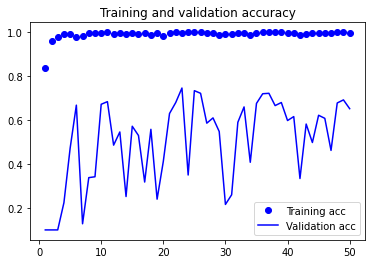

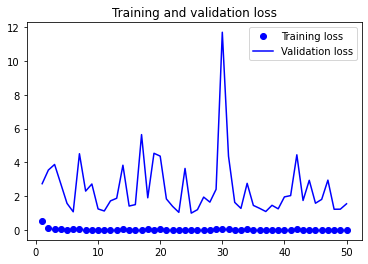

In [ ]:
#Gerando os gráficos

graph_plots(CResNET_History)

Como em vários outros estudos sobre o FSDD disponibilizados online, nós obtivemos um bom resultado com a divisão sem nenhum critério, apenas balanceando classes nos conjuntos de treino e validação. Porém, ao utilizarmos um critério mais próximo da realidade para separar os conjuntos, simulando com Jackson ou George um locutor desconhecido da rede, vimos que na verdade não houve tanto progresso, algo que não é demonstrado ou cogitado na maioria dos projetos em cima do FSDD.

Considerando que testamos outros modelos e nossa adaptação da Resnet ainda foi a que melhor performou, continuaremos investigando novas abordagens para a tarefa de classificação de áudio sejam redes neurais ou não, MFCCs ou não e, conforme forem surgindo novos progressos no projeto, atualizaremos esse notebook e seguiremos divulgando nosso trabalho para a comunidade.

Caso você tenha algum material sobre o problema que gostaria de disponibilizar, alguma dica, dúvida ou tenha identificado algum erro no que apresentamos, por favor entre em contato escrevendo para o e-mail leo.l.dionizio@gmail.com. Com certeza será um prazer atendê-los.


-------

As in multiple studys about the FSDD you can look online, we got good results with the scikit-learn train test split. But, when we used our speaker division, the one we believe being closer to the reality, using Jackson or George audios as validation sets, we finded out that actually there wasn't as many progress as we want, something that isn't shown in the mostly of the FSDD based projects.

Considering we tested another models and our ResNet adaptation was the best by far, we will keep looking forward to new approaches to the audio classification task, being it neural networks or not, MFCCs or not and, as arise of new progress in the project, we will actualize this notebook and keep spreading our work to the community.

If you have any doubts, tip, a material you think would help us or identified an error on our project, please contact us writing to the e-mail leo.l.dionizio@gmail.com. It will be a pleasure to speak to you!